# Final Project

The final project is designed to let you apply what you have learned so far, and demonstrate that you have mastered it. The submission will be graded on the correctness and performance of the execution of your analysis (50%), the ambitiousness of the problems chosen (30%), and the creativity of your questions and solutions (20%).

Your submission should include all outputs and be *self-contained*, so it can be executed if necessary.

The submission includes two parts:
1. this notebook
2. a 15-min presentation, to be held on May 8


## Submission
The project is due on ***May 07, 23:59 CET*** (counted as the time stamp when it is received). Late submissions will **not** be considered, and graded as 0! 

To submit, please:

1. copy this file and all additional data into a folder with your group ID
3. zip the folder
4. send a copy of the zip file to Dirk Hovy <dirk.hovy@unibocconi.it> and Tommaso Fornaciari <fornaciari@unibocconi.it>

***3015999 - 3017824 - 3027525 - 3013402***

## 1. Data, Preprocessing, and Annotation (4 pts)

Find a data set for text classification and a data set for structured prediction. These can be the same.
Kaggle is a good place to start, or the Google data set search. 

The data sets should have **at least 5,000** documents each. **At least 2000 instances** need to be labeled. If there is no label provided, you can annotate your own. You can get up to **3 bonus points** for annotation, depending on the amount and complexity of the annotation.

Split the data into dedicated training, development, and test sets (if they do not include these already)!

Briefly (max. 100 words!) describe the content and type of the data set, and what you are planning to look at. 

**-** *Our dataset is made up of lines from seasons 1-5 of the TV show The Big Bang Theory, only including the five main characters.<br> We retrieved the data as plain text from github, however, due to the mismatch with the source website and the numerous issues encountered, we manually cleaned it up and read it into a suitable dataframe.
We plan to look at the topic evolution over the series, see if clusters emerge in terms of words used, train a model to identify the right character given the lines and then build a text generator based on the protagonist, Sheldon.*<br><br>

Website source: https://bigbangtrans.wordpress.com <br>
Github source: https://github.com/Yulatu/TBBT-transcripts-wordcloud-NLP/tree/master/txts

Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.

**-** *Since we are dealing with dialogues, and the dialogues of the show in question are very peculiar (they mention a lot of comics related themes or terms coming from theoretical physics), in order to perform the tasks in sections 3. we had to use an approach that would keep all of these relevant elements while also removing as much noise as possible (such as the interjections). Hence, we lemmatized the text and only filtered out few POS tags and all stopwords. Also, we removed contractions, numbers, and lowercased everything. More aggressive, specific preprocessing was applied for 4.1., after some initial trials, and can be found in the relevant section. For section 4.2., in the structured prediction, instead, the dataset we will use is simply a subset of the main one, in its unprocessed form.*

In [1]:
import contractions
import nltk
import numpy as np
import random
import pandas as pd
import spacy

from nltk.corpus import stopwords
from gensim.models.phrases import Phrases, Phraser
from IPython.display import display_html

nlp = spacy.load('en',disable=['parser'])

In [2]:
data = pd.read_csv('bbt_12345.csv',index_col=[0]).dropna()
print(data.columns)
data.head()

Index(['season', 'n_episode', 'title_episode', 'character', 'line'], dtype='object')


,season,n_episode,title_episode,character,line
0,1,1,pilot episode,Sheldon,So if a photon is directed through a plane wit...
1,1,1,pilot episode,Leonard,"Agreed, what’s your point?"
2,1,1,pilot episode,Sheldon,"There’s no point, I just think it’s a good ide..."
3,1,1,pilot episode,Leonard,Excuse me?
4,1,1,pilot episode,Receptionist,Hang on.


In [3]:
protagonists = ['Sheldon','Leonard','Penny','Howard','Raj']
dataset = data[data.character.isin(protagonists)]
len(dataset)

20917

In [4]:
dataset.groupby('character')['line'].count().sort_values(ascending=False)

character
Sheldon    6281
Leonard    5650
Penny      4047
Howard     2889
Raj        2050
Name: line, dtype: int64

In [5]:
for p in protagonists:
    plines = dataset[dataset.character == p].line.tolist()
    print('%s lines are, on average'% (p),np.mean([len(i) for i in plines]), 'words')
    print('%s lines are minimum'% (p),np.min([len(i) for i in plines]), 'words')
    print('%s lines are at most'% (p),np.max([len(i) for i in plines]), 'words')
    print('')

Sheldon lines are, on average 78.45104282757522 words
Sheldon lines are minimum 3 words
Sheldon lines are at most 940 words

Leonard lines are, on average 47.89628318584071 words
Leonard lines are minimum 3 words
Leonard lines are at most 581 words

Penny lines are, on average 47.12206572769953 words
Penny lines are minimum 3 words
Penny lines are at most 869 words

Howard lines are, on average 56.49498096227068 words
Howard lines are minimum 2 words
Howard lines are at most 454 words

Raj lines are, on average 57.36487804878049 words
Raj lines are minimum 3 words
Raj lines are at most 544 words



In [6]:
corpus = dataset.line.tolist()

In [7]:
def NLP_stats(corpus):
    '''
    corpus: list of strings, each string being a document
    '''
    tot_documents = len([i for i in corpus if i != ''])

    tokens = []
    for document in corpus:
        tokens.extend(nltk.word_tokenize(document))
    tot_tokens = len(tokens)
    
    types = set(tokens)
    tot_types = len(list(types))
    print("""
    Total number of non-empty documents: {}
    Total number of tokens: {}
    Total number of types: {}""".format(tot_documents,tot_tokens,tot_types) )
    return tot_documents, tot_tokens, tot_types

In [8]:
doc,tok,typ = NLP_stats(corpus)


    Total number of non-empty documents: 20917
    Total number of tokens: 311980
    Total number of types: 17306


In [9]:
tokenizer = nltk.RegexpTokenizer(r"[A-Za-z][A-Za-z]+")
corpus = [contractions.fix(line) for line in corpus]
clean_corpus = [' '.join([word.lower() for word in tokenizer.tokenize(line) if word not in stopwords.words('english')]) 
                for line in corpus]

In [10]:
clean_corpus = [' '.join([token.lemma_ for token in nlp(i) if token.pos_ not in {'PRON','NUM','INTJ'} and token.is_stop == False]) 
           for i in clean_corpus]

In [11]:
doc_clean,tok_clean,typ_clean = NLP_stats(clean_corpus)


    Total number of non-empty documents: 18534
    Total number of tokens: 89539
    Total number of types: 11282


In [15]:
print("Compared to the raw corpus, we now have","{0:.0%}".format(1-(doc_clean/doc)), 
      "fewer non-empty documents, " "{0:.0%}".format(1-(tok_clean/tok)), "fewer tokens and",
      "{0:.0%}".format(1-(typ_clean/typ)),"fewer types")

Compared to the raw corpus, we now have 11% fewer non-empty documents, 71% fewer tokens and 35% fewer types


In [18]:
dataset.loc[:,'clean_line'] =clean_corpus
dataset = dataset.sort_values(by=['season','n_episode'],ascending=True)
dataset.head()

,season,n_episode,title_episode,character,line,clean_line
0,1,1,pilot episode,Sheldon,So if a photon is directed through a plane wit...,photon direct plane slit slit observe slit uno...
1,1,1,pilot episode,Leonard,"Agreed, what’s your point?",agree point
2,1,1,pilot episode,Sheldon,"There’s no point, I just think it’s a good ide...",point think good idea tee shirt
3,1,1,pilot episode,Leonard,Excuse me?,excuse
5,1,1,pilot episode,Leonard,"One across is Aegean, eight down is Nabakov, t...",aegean nabakov mcm finger phylum make port au ...


In [19]:
# split training, development and test sets:

dataset['set'] = np.where(dataset.season == 5, 'test', 'None')
dataset.head()

,season,n_episode,title_episode,character,line,clean_line,set
0,1,1,pilot episode,Sheldon,So if a photon is directed through a plane wit...,photon direct plane slit slit observe slit uno...,None
1,1,1,pilot episode,Leonard,"Agreed, what’s your point?",agree point,None
2,1,1,pilot episode,Sheldon,"There’s no point, I just think it’s a good ide...",point think good idea tee shirt,None
3,1,1,pilot episode,Leonard,Excuse me?,excuse,None
5,1,1,pilot episode,Leonard,"One across is Aegean, eight down is Nabakov, t...",aegean nabakov mcm finger phylum make port au ...,None


In [20]:
indices = np.array([i for i in range(len(dataset[dataset.season != 5]))])
random.seed(0)
random.shuffle(indices)

In [21]:
n = len(indices)
train_idx = [i for i in indices[:int(0.8*n)]]
dev_idx = [i for i in indices[int(0.8*n):]]

In [23]:
dataset.iloc[train_idx,dataset.columns.get_loc('set')] = 'train'
dataset.iloc[dev_idx,dataset.columns.get_loc('set')] = 'dev'
dataset.head()
#dataset.to_csv('bbt_clean.csv') 
##the dataset was created and reloaded in the sections, as they were ran on different laptop and we wanted to avoid issues.

,season,n_episode,title_episode,character,line,clean_line,set
0,1,1,pilot episode,Sheldon,So if a photon is directed through a plane wit...,photon direct plane slit slit observe slit uno...,train
1,1,1,pilot episode,Leonard,"Agreed, what’s your point?",agree point,train
2,1,1,pilot episode,Sheldon,"There’s no point, I just think it’s a good ide...",point think good idea tee shirt,dev
3,1,1,pilot episode,Leonard,Excuse me?,excuse,train
5,1,1,pilot episode,Leonard,"One across is Aegean, eight down is Nabakov, t...",aegean nabakov mcm finger phylum make port au ...,train


In [29]:
# checking that the train and dev sets are indeed balanced across characters:

#to show dataframes side by side
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

train_df = dataset[dataset.set=='train'].groupby('character')[['line']].count().sort_values(by=['character'],ascending=False).reset_index()
dev_df = dataset[dataset.set=='dev'].groupby('character')[['line']].count().sort_values(by=['character'],ascending=False).reset_index()
test_df = dataset[dataset.set=='test'].groupby('character')[['line']].count().sort_values(by=['character'],ascending=False).reset_index()

display_side_by_side(train_df, dev_df, test_df)

,character,line
0,Sheldon,4166
1,Raj,1304
2,Penny,2674
3,Leonard,3746
4,Howard,1862
,character,line
0,Sheldon,1017
1,Raj,344
2,Penny,640
3,Leonard,963


## 2. Research Question(s) (2 pts)

Describe what question you are investigating with the data (max. 100 words)

*section 3: finding main recurring topics through seasons and highlighting the characters' evolution over time*

*Section 4: given that the characters in the show are quite iconic and have a peculiar way to speak, we want to try and perform two tasks:*

*1: train a model to recognize the speaker, among the main characters, given the line*

*2: train a model to "speak like Sheldon"*

## 3. Analysis (6 pts)

Apply at least one version of *each* of the following analysis methods to the data set (justify your choices):
1. Topic modeling with LDA (3 pts). Justify your choice of number of topics!
2. Dense word embeddings ***or*** document embeddings: visualize these and show a clustering (3 pts) 

Your analysis needs to be run on the training data only! You can use the dev set for tuning.

### Other methods
If appropriate for your problem, feel free to explore other methods, as long as they do not require additional libraries (**up to 2 bonus points**).

#### ***3.1. LDA Analysis***

In this section we tried to deep dive into our dataset in order to identify topics through LDA. Due to the complexities associated with dialogues and short sentences, we decided to proceed with an exploratory attitude and tried out different solutions. In order to better understand the following analysis we briefly described the process followed:
1. At first we computed a **general LDA** on the cleaned dataset clustering by characters to capture recurrent specific topics, but this led to the conclusion that dialogues between characters refer more or less to the same topics and are distributed evenly throughout the episodes and seasons. We repeated the clustering by season and episode to validate the theory.
2. As a second approach we kept only **sentences above 15 caracters** in order to capture only lines with a higher likeihood to have a meaning, but this led to the same conclusions reached through the first analysis.
3. We then proceeded with a **hard preprocessing** in order to eliminate the noise typical of dialogues, capturing only nouns and adjectives but common verbs are really used spreadly and make it almost impossible to distinguish topics
4. Lastly, we decided to enlarge our dictionary with two different approaches adding **bigrams** and **ngrams**. 
<br><br>Here below you will find this last analysis, which ended up being the most successful.

In [1]:
import pandas as pd
import numpy as np
import spacy
import time 
import re
import nltk
import multiprocessing 
import gensim
from wordcloud import STOPWORDS
import itertools
import matplotlib.pyplot as plt

import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser','ner'])

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

#### ***Dataset Exploration***

In [2]:
df = dataset
#df = pd.read_csv('bbt_clean.csv',)
df = df[df['clean_line'].notnull()]
df = df[df['set']!='test']
df['clean_line'] = df['clean_line'].str.lower()
df = df.sort_values('set', ascending=False)
df = df.dropna(axis=1, how='any')
df = df[df.clean_line != '']
df = df.reset_index(drop=True)
df.head(3)

,season,n_episode,title_episode,character,line,clean_line,set
0,1,1,pilot episode,Sheldon,So if a photon is directed through a plane wit...,photon direct plane slit slit observe slit uno...,train
1,3,12,the psichic vortex,Leonard,"No, not at all. Let me help you with this stuff.",let help stuff,train
2,3,12,the psichic vortex,Leonard,Great.,great,train


In [3]:
# Changing the 'n_episode' column with the format 01 for 1, 02 for 2, etc. This will facilitate the anlysis later on.

df['n_episode'] = df['n_episode'].astype(str).str.zfill(2)

In [4]:
# Generate a column `code` in order to decode `season-n_episode` (eg. 2-03 for episode 3 in season 2) and be able to analyze the evolution of topics over time.

df['code'] = df['season'].astype(str) + '-' + df['n_episode'].astype(str)

In [5]:
# Repeat the same process to generate `code_long` with the following pattern `season-n_episode-title_episode`

df['code_long'] = df['season'].astype(str) + '-' + df['n_episode'].astype(str) + '-' + df['title_episode'].astype(str)

In [6]:
# Generate the list of `episodes` and `titles` and order them cronologically

episode_time_series = list(set(df['code']))
episode_time_series = sorted(episode_time_series)
episode_titles = list(set(df['code_long']))
episode_titles = sorted(episode_titles)

In [7]:
# Check seasons and number of episodes per season

season_1 = df[df['season']==1]
season_2 = df[df['season']==2]
season_3 = df[df['season']==3]
season_4 = df[df['season']==4]

print('Number of seasons:', len(set(df['season'])))

e_s1 = len(set(season_1['n_episode']))
e_s2 = len(set(season_2['n_episode']))
e_s3 = len(set(season_3['n_episode']))
e_s4 = len(set(season_4['n_episode']))

print('N° episodes in season 1:', e_s1)
print('N° episodes in season 2:', e_s2)
print('N° episodes in season 3:', e_s3)
print('N° episodes in season 4:', e_s4)

Number of seasons: 4
N° episodes in season 1: 17
N° episodes in season 2: 23
N° episodes in season 3: 23
N° episodes in season 4: 24


***General LDA***

In this first section we tried to model the full cleaned dataset adding bigrams detected as collocations. 

In [8]:
df_train = df[df['set']=='train']
df_dev = df[df['set']=='dev']
print(len(df_train), len(df_dev))
df = df.reset_index(drop=True)

12228 3029


In [9]:
documents = df.clean_line

In [10]:
# Finding bigrams and collecting them in a dict according to their frequency

stopwords_ = set(stopwords.words('english'))
words = [word.lower() for document in documents for word in document.split() 
         if len(word) > 2 
         and word not in stopwords_]

finder = BigramCollocationFinder.from_words(words)
bgm = BigramAssocMeasures()
score = bgm.mi_like

collocations = {' '.join(bigram): pmi for bigram, pmi in finder.score_ngrams(score)}
bigrams_dict = dict(Counter(collocations).most_common(50)) #only keeping the top 50 (which we found were most characteristic to the show)
bigrams_dict_underscore = bigrams_dict.copy()
for key, value in bigrams_dict_underscore.items():
    bigrams_dict_underscore[key] = key.replace(" ", "_")

In [11]:
# Adding the detected bigrams to the documents 

pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in bigrams_dict_underscore.keys()) + r')(?!\w)')

def change_bigrams(text):
    text = pattern.sub(lambda x: bigrams_dict_underscore[x.group()], text)
    return(text)

df['clean_line'] = df.apply(lambda x: change_bigrams(x.clean_line), axis=1)

In [12]:
# generating the dictionary

instances = df.clean_line.apply(str.split)
dictionary = Dictionary(instances)
dictionary.filter_extremes(no_below=10, no_above=0.2)
print(dictionary, flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]
print('Corpus generated.')

Dictionary(1212 unique tokens: ['go', 'hit', 'left', 'observe', 'help']...)
Corpus generated.


***Choosing the best number of topic***

In [13]:
coherence_values = []

dev_size = len(df_train)
eval_size = len(df_dev)
print(dev_size, eval_size)

for num_topics in range(5, 20):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         num_topics=num_topics,
                         workers=min(10, multiprocessing.cpu_count()-1), 
                         alpha=0.2) #We set a low alpha due to the nature of dialogues that in most cases are very short and dense.
    
    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[dev_size:dev_size+eval_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

12228 3029
5 -10.384605841022832 0.48681475145126873
6 -10.425505946889514 0.45136625530145896
7 -10.553990196225234 0.46954809418171417
8 -11.165902157166197 0.4787520278513532
9 -11.369880906017823 0.48959026004854245
10 -11.66995274061517 0.48283519761168014
11 -11.620039980051137 0.49807514687180016
12 -12.230251777364915 0.5078843124418846
13 -12.255763991267449 0.5052092191939069
14 -12.502524887156804 0.5126047762853825
15 -12.801427265098129 0.522683342027587
16 -13.045792187371072 0.5272903158317075
17 -12.962531781604145 0.5238459749857634
18 -13.302883170538584 0.5440557466092201
19 -13.292085528907899 0.5376018683213022


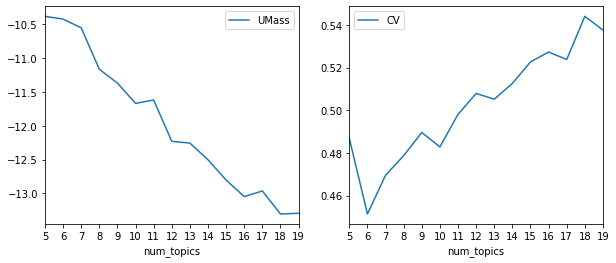

In [14]:
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,20))
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,20));

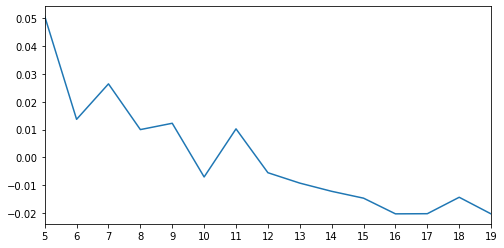

In [15]:
K_optimal = 0.5*scores['UMass']/abs(scores['UMass'].mean())+0.5*scores['CV']/scores['CV'].mean()
fig, ax = plt.subplots(figsize=(8, 4))
_ = ax.set_xticklabels([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
K_optimal.plot.line(x='num topics', y='avg score', ax=ax, xticks=range(0,15));

From the weighted average of the UMass and CV scores we can see how the choice of the optimal number of topics is between 5, 7 and 11. Using 5 or 7 topics LDA detects words based on their nature and mostly a mixture of verbs with no sense when read all together. For this reason we used 11 as a benchmark for this analysis,due to more informative descriptors.

In [16]:
k = 11

In [17]:
num_topics = k
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics,
                     corpus=model_corpus,  
                     id2word=dictionary, 
                     workers=min(10, multiprocessing.cpu_count()-1), 
                     passes=num_passes,
                     chunksize=chunk_size,
                     alpha=0.2
                    )
    
print("done in {}".format(time.time()-start), flush=True)

762.85
fitting model
done in 25.864500045776367


In [18]:
topic_corpus = model[model_corpus]
topic_sep = re.compile(r"0\.[0-9]{3}\*") 
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=10)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:10]))
    descriptors.append(", ".join(m[:10]).replace('"', ''))

1 "think", "good", "thank", "help", "night", "date", "little", "stop", "plan", "tonight"
2 "howard", "ask", "problem", "excuse", "hang", "mother", "pick", "call", "exactly", "honey"
3 "leonard", "penny", "wait", "order", "watch", "morning", "hold", "cool", "money", "matter"
4 "come", "work", "guess", "man", "leave", "point", "feel", "start", "listen", "wolowitz"
5 "right", "let", "talk", "like", "sure", "kind", "question", "play", "sound", "long"
6 "go", "sheldon", "mean", "god", "home", "suppose", "pretty", "people", "real", "party"
7 "look", "say", "love", "nice", "hear", "hell", "take", "turn", "drive", "place"
8 "maybe", "course", "find", "believe", "wrong", "live", "fun", "sit", "kid", "bernadette"
9 "know", "want", "raj", "bad", "sleep", "bring", "day", "eat", "amy", "boy"
10 "fine", "great", "happen", "sorry", "girl", "actually", "girlfriend", "mind", "meet", "give"
11 "tell", "get", "guy", "time", "need", "friend", "understand", "see", "know", "lot"


***Visualization***

We decided to plot topics on the whole timeline of the first 4 seasons with different representations in order to capture evolutions and differences overtime. And perhpas, some episode-specific peculiarities.

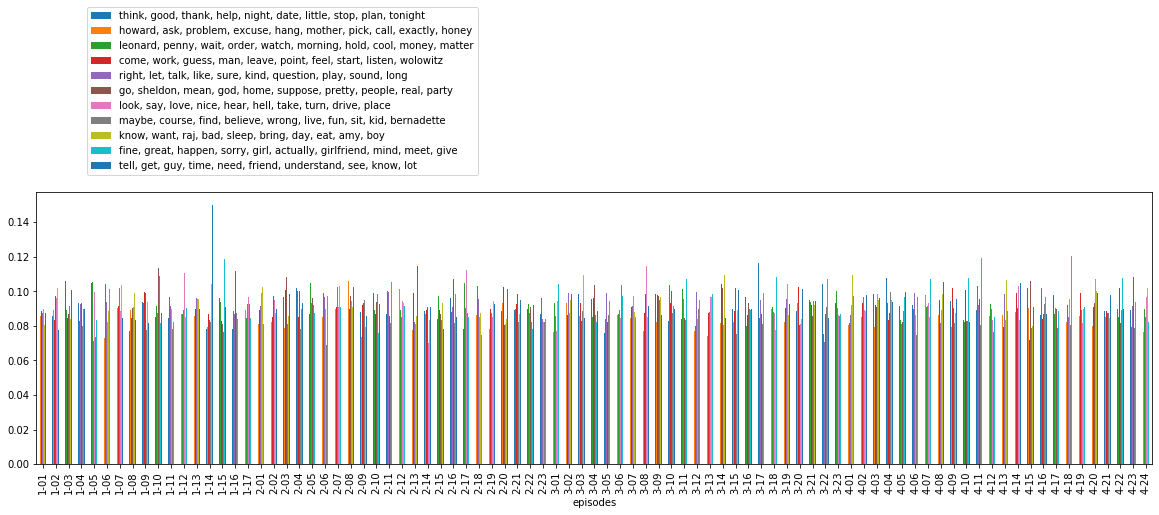

In [19]:
target_category = 'code'

scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(model_corpus))]
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
topic_distros['category'] = df[target_category]
fig, ax = plt.subplots(figsize=(20, 5))

aggregate_by_category = topic_distros[topic_distros.category.isin(episode_time_series)]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()

aggregate_by_category[descriptors].plot.bar(ax=ax)
plt.xlabel('episodes')
plt.legend(loc='best', bbox_to_anchor=(0.2,1.2,0.2,0.5));

We tried to stack them to better capture evolutions of each topic overtime.

In [20]:
data = aggregate_by_category[descriptors]
data = data.values.tolist()
data = list(map(list, zip(*data)))

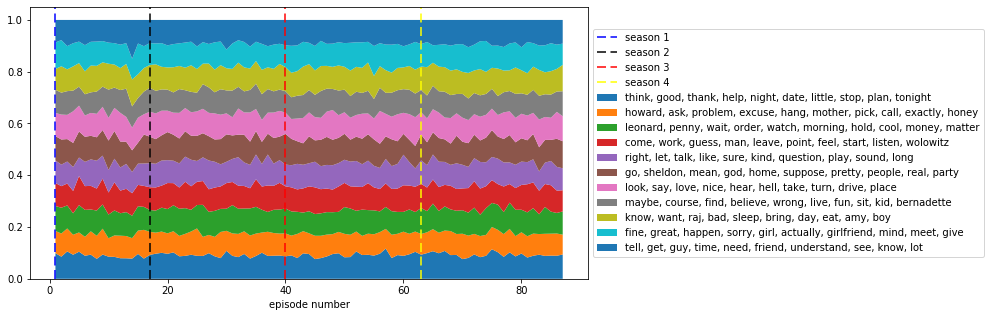

In [21]:
x=range(1,88)
y=data
fig, ax = plt.subplots(figsize=(10, 5))
plt.stackplot(x,y, labels=descriptors)
ax.axvline(x=1, linewidth=1.5, color='blue', dashes=(6,3), label='season 1')
ax.axvline(x=e_s1, linewidth=1.5, color='black', dashes=(6,3), label='season 2')
ax.axvline(x=e_s1+e_s2, linewidth=1.5, color='red', dashes=(6,3), label='season 3')
ax.axvline(x=e_s1+e_s2+e_s3, linewidth=1.5, color='yellow', dashes=(6,3), label='season 4')
plt.xlabel('episode number')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Last but not least a plot by season helped us understand if there is any recurrent topic across episodes or across seasons

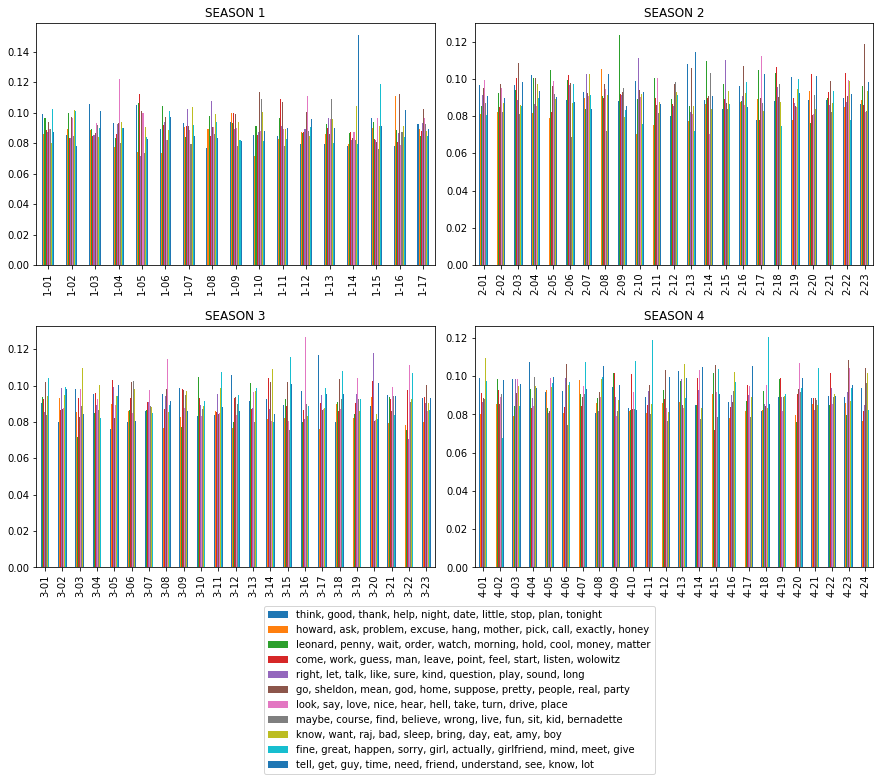

In [22]:
e_s1_start = 0
e_s2_start = e_s1_start + e_s1
e_s3_start = e_s2_start + e_s2
e_s4_start = e_s3_start + e_s3

target_category = 'code'
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(model_corpus))]
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
topic_distros['category'] = df[target_category]
fig, ax = plt.subplots(2, 2, figsize=(15,12))

aggregate_by_category_s1 = topic_distros[topic_distros.category.isin(episode_time_series[:e_s1])]
aggregate_by_category_s1 = aggregate_by_category_s1.groupby(aggregate_by_category_s1.category).mean()

aggregate_by_category_s2 = topic_distros[topic_distros.category.isin(episode_time_series[e_s2_start:e_s2_start+e_s2])]
aggregate_by_category_s2 = aggregate_by_category_s2.groupby(aggregate_by_category_s2.category).mean()

aggregate_by_category_s3 = topic_distros[topic_distros.category.isin(episode_time_series[e_s3_start:e_s3_start+e_s3])]
aggregate_by_category_s3 = aggregate_by_category_s3.groupby(aggregate_by_category_s3.category).mean()

aggregate_by_category_s4 = topic_distros[topic_distros.category.isin(episode_time_series[e_s4_start:e_s4_start+e_s4])]
aggregate_by_category_s4 = aggregate_by_category_s4.groupby(aggregate_by_category_s4.category).mean()

aggregate_by_category_s1[descriptors].plot.bar(ax=ax[0,0])
aggregate_by_category_s2[descriptors].plot.bar(ax=ax[0,1])
aggregate_by_category_s3[descriptors].plot.bar(ax=ax[1,0])
aggregate_by_category_s4[descriptors].plot.bar(ax=ax[1,1])

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.3,0.01))
ax[0,0].get_legend().remove()
ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()

ax[0,0].title.set_text('SEASON 1')
ax[0,1].title.set_text('SEASON 2')
ax[1,0].title.set_text('SEASON 3')
ax[1,1].title.set_text('SEASON 4')

ax[0,0].xaxis.set_label_text('foo')
ax[0,0].xaxis.label.set_visible(False)
ax[0,1].xaxis.set_label_text('foo')
ax[0,1].xaxis.label.set_visible(False)
ax[1,0].xaxis.set_label_text('foo')
ax[1,0].xaxis.label.set_visible(False)
ax[1,1].xaxis.set_label_text('foo')
ax[1,1].xaxis.label.set_visible(False)

plt.subplots_adjust(hspace=0.25, wspace=0.1, bottom = 0.25)

----
#### Comment on General LDA

From the analysis above we can deduce that the model is detecting topics. However, those topics are meaningless.
We can see how the topics are flexible and capture different things across episodes and seasons, but at the same time are a mix of common verbs and adjectives used a lot in spoken dialogues. Hence, from a topic detection perspective this first approach is not significant neither relevant.

----

***LDA with a twist: bigrams***

We proceeded with the addition of all possible pairs of words into our dictionary. This procedure has been done on the belief that, in dialogues, bigrams may be more informative than single words, especially in the case of a sitcom with such a specific vocabulary such as this one. For this reason we created two lists, one standard with unigrams and one with **all possible bigrams** of words in the respective sentence (Eg. 'I am going outside' will become ['I_am', 'am_going', 'going_outside']).

In [8]:
df_train = df[df['set']=='train']
df_dev = df[df['set']=='dev']
print(len(df_train), len(df_dev))

12228 3029


In [9]:
documents = df.clean_line
unigrams = df.clean_line.apply(str.split)

In [10]:
bigrams = []
for doc in documents:
    a = [doc]
    if len(a[0].split()) <= 1:
        bigrams.append([doc])
    else:
        bms = [b for l in a for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
        bigrams.append([' '.join(map(str,t)) for t in bms])

In [11]:
instances = unigrams + bigrams
instances[11]

['little', 'jealous', 'little jealous']

In [12]:
dictionary = Dictionary(instances)
dictionary.filter_extremes(no_below=10, no_above=0.6)
print(dictionary, flush=True)
print("\nTranslating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in bigrams]
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]

Dictionary(1336 unique tokens: ['go', 'hit', 'left', 'observe', 'help']...)

Translating corpus to IDs
tf-idf transformation


***Choosing the number of topic***

In [13]:
coherence_values = []

dev_size = len(df_train)
eval_size = len(df_dev)
print(dev_size, eval_size)

for num_topics in range(5, 16):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         num_topics=num_topics,
                         workers=min(10, multiprocessing.cpu_count()-1), 
                         alpha=0.1)
    
    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')
    
    #cv score won't be computed with this modified corpus

    umass_score = coherencemodel_umass.get_coherence()
    
    print(num_topics, umass_score)
    coherence_values.append((num_topics, umass_score))

12228 3029
5 -18.12293589697557
6 -18.31160858095925
7 -18.771072391929675
8 -18.64481358184682
9 -18.495714661088105
10 -18.48530146063814
11 -18.545215413248403
12 -18.52263022864069
13 -19.175396688520273
14 -18.803469640868823
15 -18.75353640815051


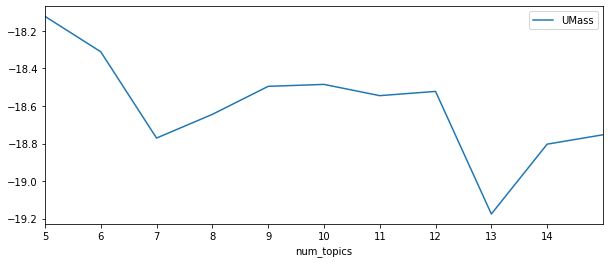

In [14]:
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass'])
fig, ax = plt.subplots(figsize=(10, 4))
scores.plot.line(x='num_topics', y='UMass', ax=ax, xticks=range(5,15));

From the the UMass scores we can see how a sensible number of topics seems to be 9.

In [15]:
k = 9

In [18]:
num_topics = k
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics,
                     corpus=model_corpus,  
                     id2word=dictionary, 
                     workers=min(10, multiprocessing.cpu_count()-1), 
                     passes=num_passes,
                     chunksize=chunk_size,
                     alpha=0.1
                    )
    
print("done in {}".format(time.time()-start), flush=True)

762.85
fitting model
done in 10.758389949798584


In [19]:
topic_corpus = model[model_corpus]
topic_sep = re.compile(r"0\.[0-9]{3}\*") 
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=10)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:8]))
    descriptors.append(", ".join(m[:8]).replace('"', ''))

1 "guy", "right", "good night", "fine", "comic book", "howard", "stan lee", "wait minute"
2 "look like", "sheldon cooper", "soft kitty", "come sheldon", "guy go", "wait", "say", "time"
3 "leonard", "think", "sound like", "talk", "chinese food", "like", "want come", "raj"
4 "thank", "great", "mean", "year old", "wait wait", "kidding", "need talk", "pretty sure"
5 "star trek", "wil wheaton", "know go", "want talk", "good luck", "guess", "course", "sheldon go"
6 "come", "penny", "want", "work", "know get", "god sake", "ask", "want know"
7 "know", "time machine", "happen", "think go", "let", "leonard hofstadter", "tell", "book store"
8 "sheldon", "good", "halo night", "good friend", "los angeles", "thai food", "god", "got"
9 "go", "look", "problem", "roommate agreement", "big deal", "penny penny", "leonard go", "know mean"


Now we can see how bigrams are used a lot more and how they detect recurrent topics in The Big Bang Theory series much better, although some issues with interpretation remain. Still, we can identify some highlights.

Below, we explain a few of them (which are only evident if one has watched the show).

- (1) comic_book book_store refers clearly to the store where the characters are used to go and shoot many scenes. Incidentally, and stan_lee.
- (9) Looks like Sheldon asking Leonard for help to solve some absolutely ridiculous situations on the basis of the infamous 'roommate agreement' to which he bounds Leonard to follow his ridiculous requests. Moreover, 'penny penny' is a common trope in the show (with Sheldon knocking at her door and calling her three times whenever he needs help). 
- (8) 'halo night' is a recurring event in which the main characters spend a night in together talking and usually playing videogames (and often having thai food). Los Angeles is where the show takes place
- (5) Here there are a few of Sheldon's idiosyncrasies: the love of star trek and Will Wheaton, a gamer and computer aficionado who is Sheldon's arch-enemy in the series. He is a minor character and appears rarely in person but he is mentioned very often.
- (7) time_machine is a topic treated in several episodes, and it follows the general trope of "nerdness" of the show's protagonist
- (2) Soft kitty is the beginning of Penny's lullaby for the sick Sheldon, another iconic recurrent moment in the show
- (6) 'for god's sake' is a common exclamation from Leonard, as is the sarcastic "Oh, great"

***Visualization***

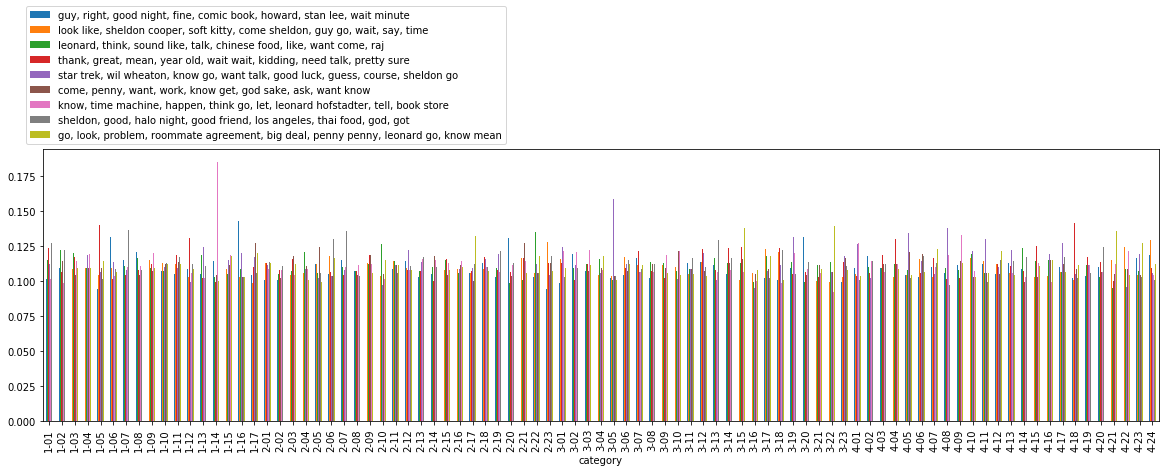

In [20]:
target_category = 'code'

scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(model_corpus))]
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
topic_distros['category'] = df[target_category]
fig, ax = plt.subplots(figsize=(20, 5))

aggregate_by_category = topic_distros[topic_distros.category.isin(episode_time_series)]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()

aggregate_by_category[descriptors].plot.bar(ax=ax)
plt.legend(loc='lower center', bbox_to_anchor=(0.2,1.0));

In [21]:
data = aggregate_by_category[descriptors]
data = data.values.tolist()
data = list(map(list, zip(*data)))

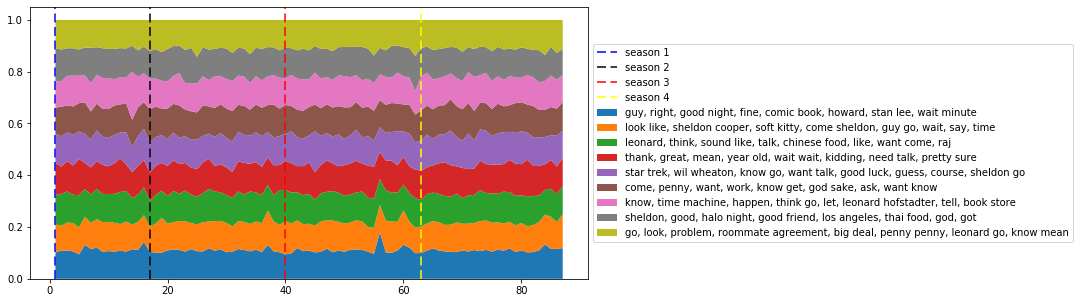

In [22]:
x=range(1,88)
y=data
fig, ax = plt.subplots(figsize=(10, 5))
plt.stackplot(x,y, labels=descriptors)
ax.axvline(x=1, linewidth=1.5, color='blue', dashes=(6,3), label='season 1')
ax.axvline(x=e_s1, linewidth=1.5, color='black', dashes=(6,3), label='season 2')
ax.axvline(x=e_s1+e_s2, linewidth=1.5, color='red', dashes=(6,3), label='season 3')
ax.axvline(x=e_s1+e_s2+e_s3, linewidth=1.5, color='yellow', dashes=(6,3), label='season 4')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show();

***Plots by Season***

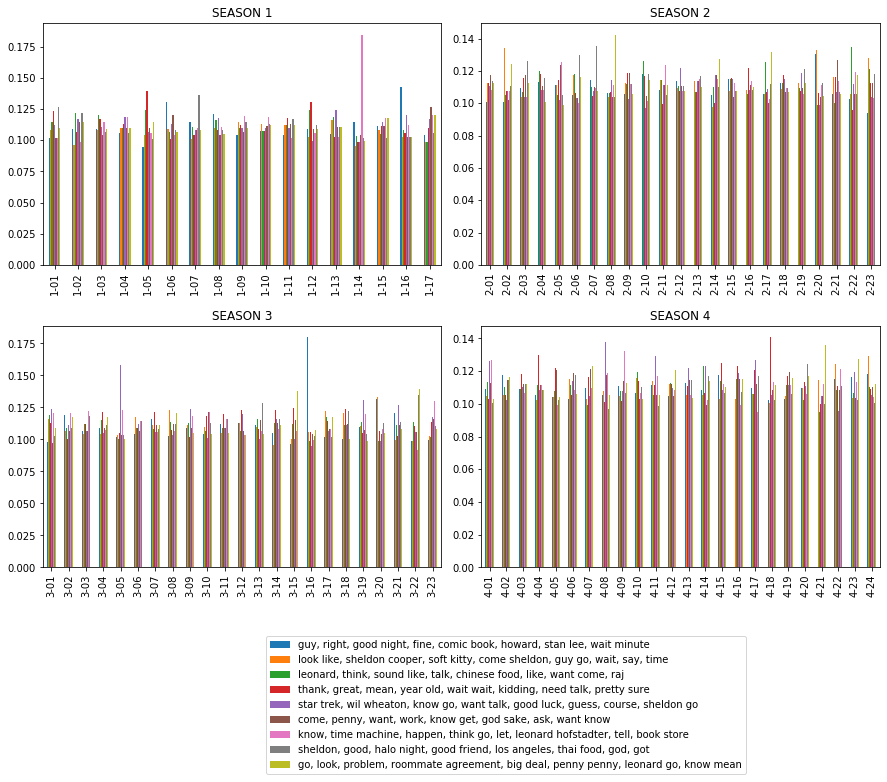

In [23]:
e_s1_start = 0
e_s2_start = e_s1_start + e_s1
e_s3_start = e_s2_start + e_s2
e_s4_start = e_s3_start + e_s3

target_category = 'code'
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(model_corpus))]
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
topic_distros['category'] = df[target_category]
fig, ax = plt.subplots(2, 2, figsize=(15,12))

aggregate_by_category_s1 = topic_distros[topic_distros.category.isin(episode_time_series[:e_s1])]
aggregate_by_category_s1 = aggregate_by_category_s1.groupby(aggregate_by_category_s1.category).mean()

aggregate_by_category_s2 = topic_distros[topic_distros.category.isin(episode_time_series[e_s2_start:e_s2_start+e_s2])]
aggregate_by_category_s2 = aggregate_by_category_s2.groupby(aggregate_by_category_s2.category).mean()

aggregate_by_category_s3 = topic_distros[topic_distros.category.isin(episode_time_series[e_s3_start:e_s3_start+e_s3])]
aggregate_by_category_s3 = aggregate_by_category_s3.groupby(aggregate_by_category_s3.category).mean()

aggregate_by_category_s4 = topic_distros[topic_distros.category.isin(episode_time_series[e_s4_start:e_s4_start+e_s4])]
aggregate_by_category_s4 = aggregate_by_category_s4.groupby(aggregate_by_category_s4.category).mean()

aggregate_by_category_s1[descriptors].plot.bar(ax=ax[0,0])
aggregate_by_category_s2[descriptors].plot.bar(ax=ax[0,1])
aggregate_by_category_s3[descriptors].plot.bar(ax=ax[1,0])
aggregate_by_category_s4[descriptors].plot.bar(ax=ax[1,1])

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.3,0.01))
ax[0,0].get_legend().remove()
ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()

ax[0,0].title.set_text('SEASON 1')
ax[0,1].title.set_text('SEASON 2')
ax[1,0].title.set_text('SEASON 3')
ax[1,1].title.set_text('SEASON 4')

ax[0,0].xaxis.set_label_text('foo')
ax[0,0].xaxis.label.set_visible(False)
ax[0,1].xaxis.set_label_text('foo')
ax[0,1].xaxis.label.set_visible(False)
ax[1,0].xaxis.set_label_text('foo')
ax[1,0].xaxis.label.set_visible(False)
ax[1,1].xaxis.set_label_text('foo')
ax[1,1].xaxis.label.set_visible(False)

plt.subplots_adjust(hspace=0.25, wspace=0.1, bottom = 0.25)

As seen before those bigrams are used frequently and they are succesfull in detecting recurring topics in The Big Bang Theory series. Here below are some clear examples.
1. (1-14-The Nerdvana Annihilation) Penny gets mad at the guys when their full scale model of a **time machine** causes her to miss work, which prompts Leonard to give up all of his nerd memorabilia.
2. (2-20-The Hofstadter Isotope) Leonard is upset when the owner of the **comic book store** goes on a date with Penny, so he convinces Howard and Raj to take him to a bar so that he can pick up a woman of his own.
3. (3-05-The Creepy Candy Coating Corollary) Sheldon takes part in a cards tournament but he finds out that **Wil Wheaton**, his arch-enemy is also participating. 
3. (3-16-The Excelsior Acquisition) Sheldon misses an opportunity to get **Stan Lee's** autograph because he has to make an appearance in traffic court.
4. (4-13-The Love Car Displacement) Chaos ensues when the gang spend the weekend together at a science convention (**star trek**)

----
#### Comment on 'LDA with a twist'
Generally we can see how with the General LDA approach + standard bigrams we capture better fluctuations in topics with more peaks but less interpretability, given lots of verbs and random words. On the other hand, with the second approach, adding all possible bigrams we lose in flexibility but we can beter detect the main topics recurrent during the series.

----

#### ***Extra: Non-negative Matrix Factorization***

As a last attempt, we decided to perform Latent Topic NMF in order to compare the results and see if we could have some better identification. To better compare it with the results of our "LDA with a twist" we excluded unigrams.

In [21]:
documents = df.clean_line.apply(str).tolist()

In [22]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,4), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.0008, 
                                   max_df=0.3, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(documents)

print(X.shape)

(15257, 67)


In [23]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=12, init='nndsvd', random_state=4)
%time W = nmf.fit_transform(X)
H = nmf.components_

CPU times: user 1.26 s, sys: 107 ms, total: 1.37 s
Wall time: 702 ms


In [24]:
def show_topics(A, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

terms = tfidf_vectorizer.get_feature_names()
show_topics(H, terms, 5)

['comic book, book store, comic book store, happen thursday, right let',
 'good night, roommate agreement, good luck, know maybe, little bit',
 'look like, year old, hey sheldon, god sake, pretty good',
 'star trek, leonard hofstadter, know tell, sheldon think, roommate agreement',
 'time machine, want come, look like, want know, know talk',
 'sound like, amy farrah, amy farrah fowler, farrah fowler, let tell',
 'want talk, know leonard, know want, good morning, want know',
 'stan lee, want know, good good, know talk, know want',
 'penny penny, penny penny penny, good morning, god sake, year old',
 'sheldon cooper, dr sheldon, dr sheldon cooper, leonard hofstadter, good morning',
 'wait wait, soft kitty, comic book, god sake, year old',
 'wil wheaton, sheldon cooper, big deal, god sake, year old']

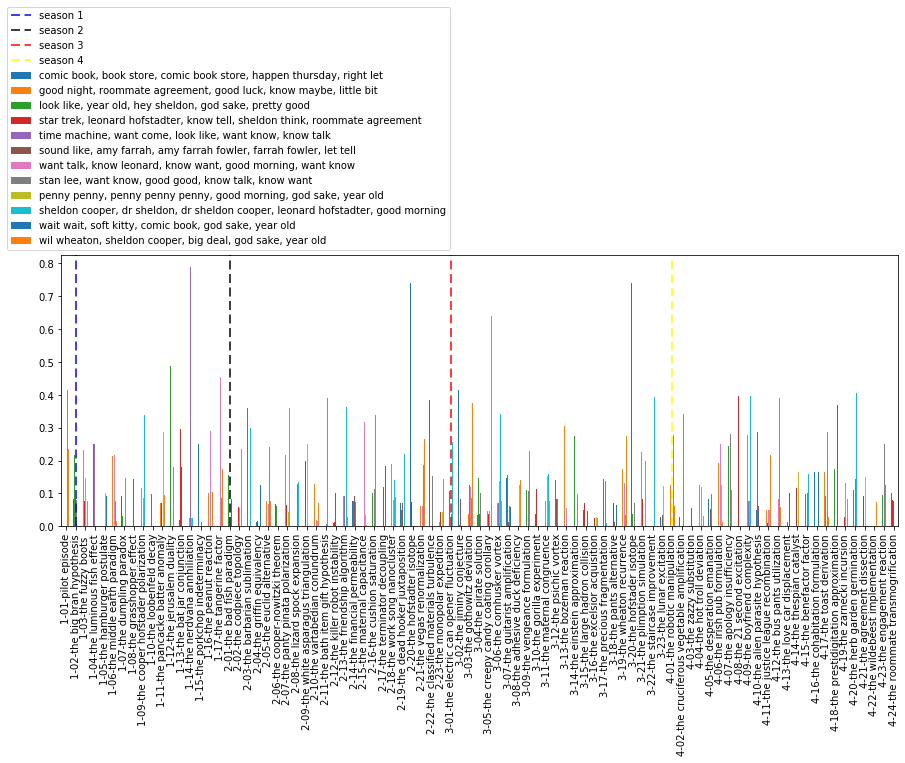

In [25]:
target_category = 'code_long'
np.seterr(divide='ignore',invalid='ignore')

A = W / np.sum(W, axis=1, keepdims=True)
scores = A

NMF_descriptors = show_topics(H, terms, 5)
topic_distros = pd.DataFrame(data=scores, columns=NMF_descriptors)
topic_distros['category'] = df[target_category]

fig, ax = plt.subplots(figsize=(15, 5))

aggregate_by_category = topic_distros[topic_distros.category.isin(episode_titles)]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()
ax.axvline(x=1, linewidth=1.5, color='blue', dashes=(6,3), label='season 1')
ax.axvline(x=e_s1, linewidth=1.5, color='black', dashes=(6,3), label='season 2')
ax.axvline(x=e_s1+e_s2, linewidth=1.5, color='red', dashes=(6,3), label='season 3')
ax.axvline(x=e_s1+e_s2+e_s3, linewidth=1.5, color='yellow', dashes=(6,3), label='season 4')
ax.xaxis.set_label_text('foo')
ax.xaxis.label.set_visible(False)

aggregate_by_category[NMF_descriptors].plot.bar(ax=ax)
plt.legend(loc='lower center', bbox_to_anchor=(0.2,1.0));

We now normalized the scores on 1 to capture the evolution overtime

In [26]:
data = aggregate_by_category[NMF_descriptors]
data = data.values.tolist()
data = list(map(list, zip(*data)))

In [27]:
cm = plt.get_cmap('gist_ncar') #tab20b
colors = [cm(1. * i/12) for i in range(12)]

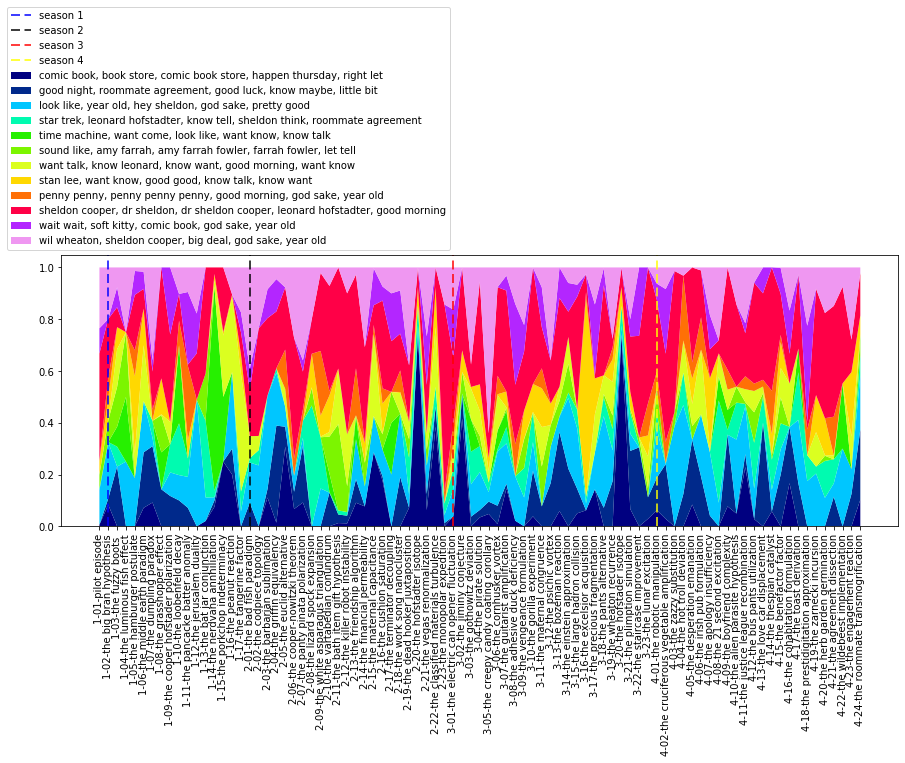

In [28]:
x=episode_titles
y=data
from matplotlib import cm

fig, ax = plt.subplots(figsize=(15, 5))
plt.stackplot(x,y, labels=NMF_descriptors, colors = colors)
ax.axvline(x=1, linewidth=1.5, color='blue', dashes=(6,3), label='season 1')
ax.axvline(x=e_s1, linewidth=1.5, color='black', dashes=(6,3), label='season 2')
ax.axvline(x=e_s1+e_s2, linewidth=1.5, color='red', dashes=(6,3), label='season 3')
ax.axvline(x=e_s1+e_s2+e_s3, linewidth=1.5, color='yellow', dashes=(6,3), label='season 4')
plt.legend(loc='lower center', bbox_to_anchor=(0.2,1.0))
plt.xticks(rotation=90)
plt.show()

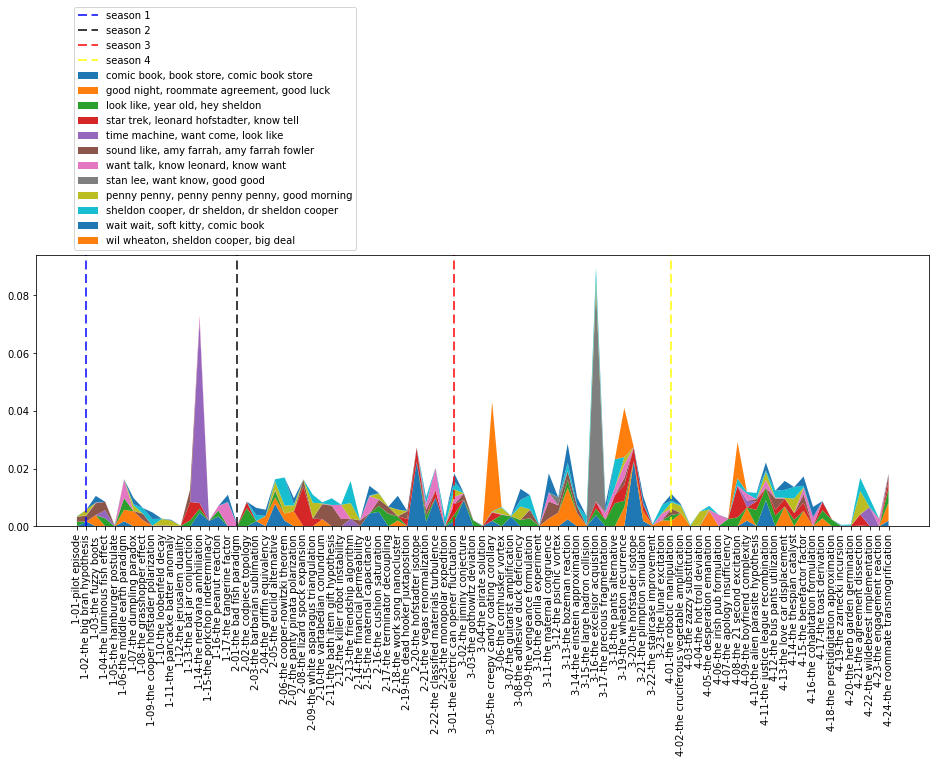

In [29]:
target_category = 'code_long'

scores = W
NMF_descriptors = show_topics(H, terms, 3)
topic_distros = pd.DataFrame(data=scores, columns=NMF_descriptors)
topic_distros['category'] = df[target_category]

aggregate_by_category = topic_distros[topic_distros.category.isin(episode_titles)]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()
data = aggregate_by_category[NMF_descriptors]
data = data.values.tolist()
data = list(map(list, zip(*data)))
x=episode_titles
y=data

fig, ax = plt.subplots(figsize=(16, 5))
plt.stackplot(x,y, labels=NMF_descriptors)
ax.axvline(x=1, linewidth=1.5, color='blue', dashes=(6,3), label='season 1')
ax.axvline(x=e_s1, linewidth=1.5, color='black', dashes=(6,3), label='season 2')
ax.axvline(x=e_s1+e_s2, linewidth=1.5, color='red', dashes=(6,3), label='season 3')
ax.axvline(x=e_s1+e_s2+e_s3, linewidth=1.5, color='yellow', dashes=(6,3), label='season 4')
plt.legend(loc='lower center', bbox_to_anchor=(0.2,1.0))
plt.xticks(rotation=90)
plt.show()

----
**Comment on NMF**<br>

As we expected Latent Topic NMF (excluding unigrams) is capturing quite well the topics identified before through LDA 'with a twist'. 

- Comic Book [comic book, book store, comic book store, ...]
- Time Machine [time machine, want come, look like, ...]
- Stan Lee [stan lee, want know, good good, ...]
- Penny [penny penny, penny penny penny, good morning, ...]
- Wil Weathon [wil wheaton, sheldon cooper, big deal, ...]
- Star Trek [star trek, leonard hofstadter, roommate agreement, ...]

As we can see the above mentioned topics are easily identifiable compared to the previous analysis. The same explanation mentioned above is valid and we can compare the results through the last graphical representation.

----

### 3.2 Embeddings

In [1]:
import pandas as pd
import numpy as np
import re
import os
import numpy as np
from gensim.models import Doc2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.models.doc2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sb
import spacy
import multiprocessing
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

In [2]:
df = pd.read_csv('bbt_clean.csv')
df = df.dropna(how = 'any')
df.clean_line = df.clean_line.astype(str)
sent = [row.split() for row in df['clean_line']]
phrases = Phrases(sent, min_count=5, progress_per=100)
bigram = Phraser(phrases)
sentences = bigram[sent]
df['clean_line'] = [' '.join(row) for row in sentences]
df_train = df[df.set == 'train']

Big Bang Theory is one of the most successful TV series of all time. Surely the ability of the actors played a role in this achievement but especially the hard work of the authors should be praised for all this success. They not only invented iconic characters (Sheldon is now part of the pop culture), but they also keep reinventing them (the unexperienced Penny of the first season is not comparable to the Penny of the ninth season).

In this analysis, we wanted to determine whether we can grasp this character evolution by analysing the transcripts. 
1. Firstly we created some general Dense word embeddings to retrieve the most related words to each character;
2. Secondly we specified the word embeddings for each season of the training set and observed how the most similar words for each character vary.

*Disclaimer: working with dialogues we should acknowledge the fact that we do not necessarily get the personality traits of the character when we look, for example, at the word "Leonard" but we simply get a gist of how other people refer to them.*

#### General W2V

In [3]:
#lower
sentences = [row.lower().split() for row in df_train.clean_line]
min_df = 5
w2v_model = Word2Vec(min_count=10,
                     window=5,
                     size=50,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=-1)

w2v_model.build_vocab(sentences, progress_per=100)

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
w2v_model.init_sims(replace=True) 

In [4]:
character = ['sheldon', 'leonard', 'penny', 'raj', 'howard']
df = pd.DataFrame()
for i in range(len(character)):
    top_words = w2v_model.wv.most_similar(positive=character[i])
    words , scores = zip(*top_words)
    character_df = pd.DataFrame({'character': [character[i]]*10*2, 'values': words + scores , 'position': [i for i in range(1,11)]*2, 'type': ['word']*10 + ['similarity']*10})
    df = pd.concat([df, character_df], sort = False)

df.set_index(['character', 'type', 'position']).unstack() 

values                                             \
position                    1          2           3         4         5    
character type                                                              
howard    similarity  0.469001   0.460795    0.414414  0.403546  0.401121   
          word             say     wonder        star      shop     train   
leonard   similarity  0.399692   0.369727    0.365701  0.364308  0.349607   
          word        electron   language  good_night    corner    palace   
penny     similarity  0.499401    0.49523    0.468608  0.460863  0.412858   
          word          common       wait        lady    palace     clock   
raj       similarity  0.583215   0.463633    0.390347  0.362002  0.360791   
          word           white  ice_cream         car      drug   science   
sheldon   similarity  0.392127   0.391355    0.383884    0.3618  0.360182   
          word           match     middle          mr     kitty      ball   

                                                                            
position                     6         7            8         9         10  
character type                                                              
howard    similarity   0.382445  0.374403     0.363779  0.346169  0.345037  
          word         response     light          leg     power      term  
leonard   similarity   0.343125  0.342155      0.33112  0.328182  0.327023  
          word         discover      base  interesting       tea   awkward  
penny     similarity   0.395135  0.391836     0.379468  0.366637   0.34982  
          word        apartment      loud         mail     bring     laugh  
raj       similarity   0.353369  0.346035     0.345753  0.341094  0.341017  
          word            focus      zone        bring       job      plan  
sheldon   similarity    0.32818  0.327241     0.323522  0.320237  0.315264  
          word            cruel      fall       defeat       tea      late

In this case the Word2vec identified words that appear closely related to the mention of the character's name. For instance:
- Penny is indeed referred to as a "lady", especially being the only woman of the group for the first seasons, and lives in the apartment next to Leonard and Sheldon. She is also, indeed, a "common" person as in she is the only non-brainy one of the group.
- Sheldon is associated with "kitty", from the infamous lullaby that he requests others sing to him when he is sick. Mr is likely related to mr. Spock, from Star Trek, who he is obsessed with. He's also often referred to as cruel due to his unability to empathise with others' feelings. 
- Leonard is mentioned toghether with electrons, which is what he deals with in his job, awkward (a very apt description of him) and palace, from "Schezchuan Palace", the chinese place they order food from whenever they have a night in. 
- Howard is mentioned with words like "start", "wonder", "light", "power" which mainly relate to superheroes, one of his passions.
- Raj is indeed a scientist as well, and usually gets involved in the ridicolous plans (plan, focus, zone) that Howard or Leonard devise. "White" may refer to the recurring joke around Raj being from a very traditional, rich and over-bearing Indian family.

Depending on the seed, top 10 may vary slightly but they still make sense in correlation with the character: the word embedding seems to work fairly well on this dataset.

#### W2V by season

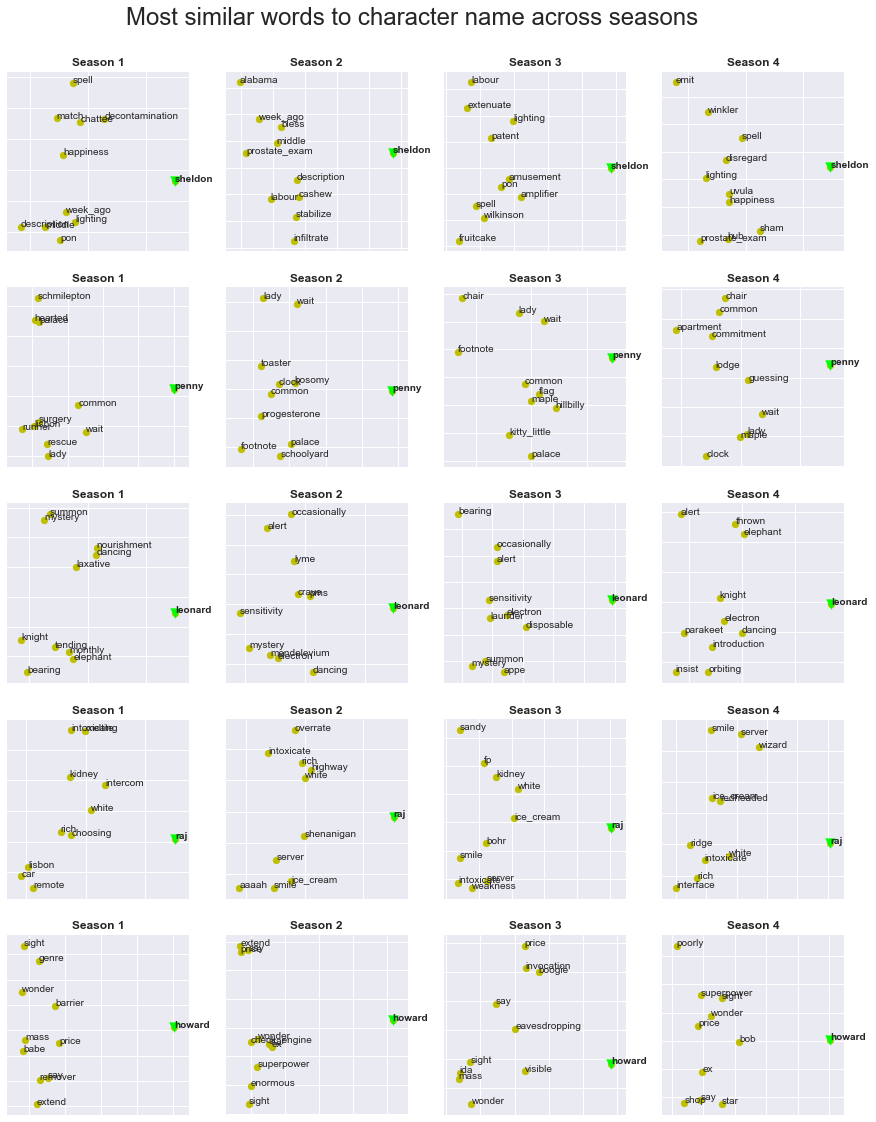

In [5]:
svd = TruncatedSVD(n_components=2)
plt.style.use('seaborn')
fig, ax = plt.subplots(5,4, facecolor='w', figsize=(15,18))
fig.suptitle('Most similar words to character name across seasons', fontsize=24)
fig.subplots_adjust(top=0.93)
characters = ['sheldon', 'penny', 'leonard', 'raj', 'howard']

for season in [1,2,3,4]: 
      

        df_train_season_specific = df_train[df_train.season == season]
        sentences = [row.lower().split() for row in df_train_season_specific.clean_line]

        w2v_model_season_specific = Word2Vec(min_count=0,
                             window=2,
                             size=50,
                             sample=6e-5, 
                             alpha=0.03, 
                             min_alpha=0.0007, 
                             negative=30,
                             workers=-1)        

        w2v_model_season_specific.build_vocab(sentences, progress_per=100)
        w2v_model_season_specific.train(sentences, total_examples=w2v_model_season_specific.corpus_count, epochs=500, report_delay=1)
        w2v_model_season_specific.init_sims(replace=True)
        
        for character in range(len(characters)):   
        
            similar_words=w2v_model_season_specific.wv.most_similar(characters[character])
            terms=[t for t,v in similar_words] + [characters[character]]
            vectors = w2v_model_season_specific.wv[terms]
            words = terms
            
            svd = TruncatedSVD(n_components=2)
            U = svd.fit_transform(vectors)

            ax[character,(season -1)].scatter(U[:,0], U[:,1],marker='o',color='y')
            for i in range(10):
                ax[character,(season -1)].annotate(words[i], (U[i,0], U[i,1]))
            ax[character,(season -1)].scatter(U[10,0], U[10,1],marker='v',color='lime',s=100)
            ax[character,(season -1)].annotate(characters[character], (U[10,0], U[10,1]),weight='bold')
            ax[character,(season -1)].set_title('Season {}'.format(season),weight='bold')
            ax[character,(season -1)].tick_params('both', labelbottom= False, labelleft = False)
        
    

The results do not allow an interpretation of the meaning of the output, showing no evidence of the evolution of the characters in the various seasons. These not very satisfactory results are probably attributable to the dialogue nature of the analyzed text. 

### Clustering

The episodes of the Big Bang Theory have covered a wide range of topics, from relationships and love to science. Given the great heterogeneity of the topics and the relatively specialized jargon, we wondered if it is possible to cluster words in such a way to recognize the "sectorial language" of the different themes.
For interpretability reason, we decided to focus on a subset of the top 200 most important/significant (according to tfidf and idf) words and performed two different clustering methods.

In [21]:
#setting a random state
np.random.seed(0)
lines = df_train.clean_line.str.lower().tolist()
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', sublinear_tf=True)
X = tfidf_vectorizer.fit_transform(lines)
df_tfidf = pd.DataFrame(data={'word': tfidf_vectorizer.get_feature_names(),'tfidf': X.sum(axis=0).A1, 'idf': tfidf_vectorizer.idf_ })

In [22]:
sentences = [row.lower().split() for row in df_train.clean_line]

w2v_model = Word2Vec(min_count=0,
                     window=5,
                     size=50,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=-1)

w2v_model.build_vocab(sentences, progress_per=100)

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
w2v_model.init_sims(replace=True) #

***Tfidf top-200***

Performing clustering on the 200 words with the highest tfidf:

In [23]:
top_tfidf = df_tfidf.sort_values('tfidf', ascending = False).reset_index(drop = True).head(200)
word_to_cluster = top_tfidf.word.tolist()

Choosing the number of cluster according to the silhouette score for both KMeans and Agglomerative method:

In [24]:
# choosing the best model
score_km = []
score_agg = []
for k in range(3, 20):    
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100)
    agg = AgglomerativeClustering(n_clusters=k, linkage = 'complete') 
    X = km.fit(w2v_model.wv[word_to_cluster])
    X = agg.fit(w2v_model.wv[word_to_cluster])
    labels_km=km.labels_.tolist() 
    labels_agg=agg.labels_.tolist()    
    score_km.append(silhouette_score(w2v_model.wv[word_to_cluster], labels_km))
    score_agg.append(silhouette_score(w2v_model.wv[word_to_cluster], labels_agg))

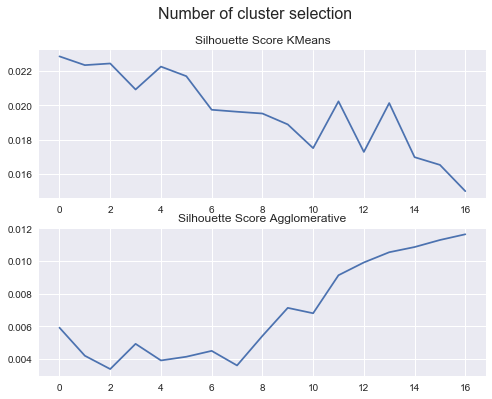

In [25]:
plt.style.use('seaborn')
fig, ax = plt.subplots(2,1, facecolor='w', figsize=(8,6))
fig.suptitle('Number of cluster selection', fontsize=16)
ax[1].set_title('Silhouette Score Agglomerative')
ax[0].set_title('Silhouette Score KMeans')
ax[0].plot(score_km)
ax[1].plot(score_agg);

In [26]:
best_km = 4 #2 would be hardly significative
best_agg = 16

Identifying the clusters formed by two different algorithms:

In [27]:
#K-Means
km = KMeans(n_clusters=best_km, init='k-means++', max_iter=100)
X = km.fit(w2v_model.wv[word_to_cluster])
labels=km.labels_.tolist()
df_clustering = pd.DataFrame({'word': word_to_cluster, 'cluster': labels})
num_word = 25
df_clus = pd.DataFrame({'clus_1': df_clustering[df_clustering.cluster == 0].word.head(num_word).reset_index(drop=True) })
for i in range(1,best_km):
    df_clus['clust_{}'.format(i+1)] = df_clustering[df_clustering.cluster == i].word.head(num_word).reset_index(drop=True)
df_clus.head(15)

,clus_1,clust_2,clust_3,clust_4
0,know,come,good,want
1,sheldon,let,tell,penny
2,leonard,talk,mean,think
3,thank,say,great,look
4,right,time,ask,guy
5,like,howard,happen,thing
6,work,friend,way,raj
7,fine,little,start,god
8,need,hear,guess,help
9,wait,new,mother,course


In [28]:
#AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=best_agg, linkage = 'complete')
X = agg.fit(w2v_model.wv[word_to_cluster])
labels=agg.labels_.tolist()
df_clustering = pd.DataFrame({'word': word_to_cluster, 'cluster': labels})
num_word = 25
df_clus = pd.DataFrame({'clus_1': df_clustering[df_clustering.cluster == 0].word.head(num_word).reset_index(drop=True) })
for i in range(1,best_agg):
    df_clus['clust_{}'.format(i+1)] = df_clustering[df_clustering.cluster == i].word.head(num_word).reset_index(drop=True)
df_clus.head(15)

,clus_1,clust_2,clust_3,clust_4,clust_5,clust_6,clust_7,clust_8,clust_9,clust_10,clust_11,clust_12,clust_13,clust_14,clust_15,clust_16
0,howard,come,say,let,god,thank,talk,want,happen,time,know,leonard,sheldon,night,mean,kind
1,great,little,date,friend,nice,fine,guy,tell,point,way,good,penny,think,fun,work,girlfriend
2,help,hear,listen,ask,problem,sure,try,believe,girl,hang,like,look,right,play,sorry,understand
3,start,man,long,bad,turn,course,new,mother,place,year,need,thing,remember,hell,money,feel
4,excuse,live,drive,bernadette,comic_book,maybe,sit,sex,drink,buy,guess,raj,late,stop,game,amy
5,home,day,forget,morning,sister,leave,love,hold,pick,boy,wrong,wait,lucky,question,ma,idea
6,sleep,mind,dinner,stay,lot,actually,big,plan,priya,pretty,suppose,people,NaN,make,door,reason
7,meet,head,room,cool,relationship,care,watch,kid,walk,bye,eat,woman,NaN,tonight,NaN,stand
8,probably,apartment,wear,life,thought,matter,better,mom,stupid,science,change,bring,NaN,stuff,NaN,NaN
9,alright,order,use,bed,smart,movie,wolowitz,funny,kill,NaN,team,break,NaN,party,NaN,NaN


The clustering results of the words with the highest Tfidf were not satisfactory. This could be because the **tf** component might be prevailing and therefore the words selected are common use words that are not meant for this analysis.\
Thus we tried to cluster the word with the highest **idf** (those words might better represent the 'specialized jargons' we are looking for).

***Idf top-200***

In [29]:
top_idf = df_tfidf.sort_values('idf', ascending = False).reset_index(drop = True).head(200)
word_to_cluster = top_idf.word.tolist()

Choosing the number of cluster according to the silhouette score for both KMeans and Agglomerative method:

In [30]:
# choose the best model
score_km = []
score_agg = []
for k in range(3, 20):    
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100)
    agg = AgglomerativeClustering(n_clusters=k, linkage = 'complete') #{“ward”, “complete”, “average”, “single”},
    X = km.fit(w2v_model.wv[word_to_cluster])
    X = agg.fit(w2v_model.wv[word_to_cluster])
    labels_km=km.labels_.tolist() 
    labels_agg=agg.labels_.tolist()    
    score_km.append(silhouette_score(w2v_model.wv[word_to_cluster], labels_km))
    score_agg.append(silhouette_score(w2v_model.wv[word_to_cluster], labels_agg))

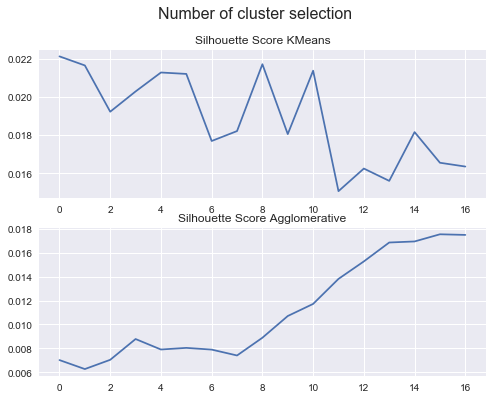

In [31]:
plt.style.use('seaborn')
fig, ax = plt.subplots(2,1, facecolor='w', figsize=(8,6))
fig.suptitle('Number of cluster selection', fontsize=16)
ax[1].set_title('Silhouette Score Agglomerative')
ax[0].set_title('Silhouette Score KMeans')
ax[0].plot(score_km)
ax[1].plot(score_agg);

In [32]:
best_km = 8
best_agg = 15

Again we identified the clusters formed by two different algorithms:

In [33]:
km = KMeans(n_clusters=best_km, init='k-means++', max_iter=100)
X = km.fit(w2v_model.wv[word_to_cluster])
labels=km.labels_.tolist()
df_clustering = pd.DataFrame({'word': word_to_cluster, 'cluster': labels})
num_word = 25
df_clus = pd.DataFrame({'clust_1': df_clustering[df_clustering.cluster == 0].word.head(num_word).reset_index(drop=True) })
for i in range(1,best_km):
    df_clus['clust_{}'.format(i+1)] = df_clustering[df_clustering.cluster == i].word.head(num_word).reset_index(drop=True)
df_clus.head(15)

,clust_1,clust_2,clust_3,clust_4,clust_5,clust_6,clust_7,clust_8
0,prowl,frustrate,functional,provoke,zzz,funk,funky,provisionally
1,furthermore,freemont,fugitive,fu,proximal,provocative,fuddrucker,frustratingly
2,prototype,frequent,gagh,prosper,fully,fulcrum,furry,puffery
3,gah,geneticist,fuzzy,protection,proximity,prudent,proton,psst
4,gabby,professional,futile,fuse,fuzzyboots,furniture,friction,psychiatric
5,fuzz,gene,fruitcake,psh,fusion,futility,freudian,frostbite
6,prototyper,procure,psychotherapist,psychotherapy,puff,psychology,puke,frolic
7,puffing,proctologist,frege,friendmaking,frigid,psychics,pulp,fritz
8,pullman,geography,friggety,puddle,producer,frosting,frightened,geiger
9,frivolous,procreate,friggin,freshener,productivity,psychologically,galactic,genie


In [34]:
agg = AgglomerativeClustering(n_clusters=best_agg, linkage = 'complete')
X = agg.fit(w2v_model.wv[word_to_cluster])
labels=agg.labels_.tolist()
df_clustering = pd.DataFrame({'word': word_to_cluster, 'cluster': labels})
num_word = 25
df_clus = pd.DataFrame({'clus_1': df_clustering[df_clustering.cluster == 0].word.head(num_word).reset_index(drop=True) })
for i in range(1,best_agg):
    df_clus['clust_{}'.format(i+1)] = df_clustering[df_clustering.cluster == i].word.head(num_word).reset_index(drop=True)
df_clus.head(10)

,clus_1,clust_2,clust_3,clust_4,clust_5,clust_6,clust_7,clust_8,clust_9,clust_10,clust_11,clust_12,clust_13,clust_14,clust_15
0,prowl,frustrate,zzz,funk,gagh,funky,provisionally,protection,provocative,fu,fuzzyboots,proximity,proximal,prototype,psychotherapist
1,fulcrum,furthermore,functional,provoke,psst,puffery,fuzz,fuse,fully,furniture,friggin,friction,fuddrucker,fuzzy,gei
2,prudent,proton,furry,fugitive,psychiatric,frightened,frustratingly,psh,futile,gah,frisbee,frequent,gabby,fruitcake,proceeding
3,prototyper,futility,propulsion,prosper,frigid,psychologism,friggety,psychotherapy,freemont,freshener,geography,gene,puffing,frivolous,flintstone
4,fusion,freudian,gena,friendmaking,producer,galapagos,psychics,frisk,fritz,pulp,geographic,genuine,generate,genus,ranakpur
5,puff,puke,geiger,puddle,gel,generalization,frosting,procyon,professional,frontal,gangrene,genre,proprietor,procreate,focusse
6,pullman,psychology,proper,prospect,genocide,genie,frostbite,proficiency,proctologist,prophylactic,gambol,gang,promote,gaming,NaN
7,frege,galactic,properly,proficient,gangrenous,geese,geology,genuinely,geologist,ramble,gastrointestinal,propter,programmable,ganglia,NaN
8,frolic,gentile,promiscuity,procure,gambling,progesterone,prone,flipping,fishing,floppy,floaty,gastronomically,projectile,gatorade,NaN
9,psychologically,ganges,gardener,geometric,gangster,games,gasses,flee,reactor,NaN,ragtag,gasoline,foam,pummel,NaN


Unfortunately even in this case it is not possible to give an interpretation. This not very encouraging result can be attributed to the type of text analyzed, that is the dialogues; in fact, unlike the description of the scene, the dialogues tend to have a limited language and the sense of the scene is given more by the interaction between the characters than by the sense of the single line itself.

#### ***EXTRA: Doc2Vec on episodes***

Performing a Doc2Vec using as tags the episodes' names in order to see whether it is possible to guess the plot by the most similar word to the episodes vector.

In [35]:
len(df_train.title_episode.unique())

87

In [36]:
def get_terms_vectors(id):
    similar_words=d2v_model.wv.most_similar([d2v_model.docvecs[id]])
    terms=[t for t,v in similar_words]
    vectors = np.append(w2v_model.wv[terms], w2v_model.docvecs[id])
    terms = terms + [id]
    return vectors ,terms

In [51]:
svd = TruncatedSVD(n_components=2)
lines = df_train.clean_line.str.lower().tolist()
tags = df_train.title_episode.tolist()

tagged_lines = []
for docids , line in enumerate(lines):
    tagged_lines.append(TaggedDocument( line.split(), [tags[docids]] ))

d2v_model = Doc2Vec(vector_size=50, 
                    window=5,
                    hs=0,
                    sample=0.000001,
                    negative=5,
                    min_count=10,
                    workers=-1,
                    epochs=100,
                    dm=0, 
                    dbow_words=1)

d2v_model.build_vocab(tagged_lines)
d2v_model.train(tagged_lines, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

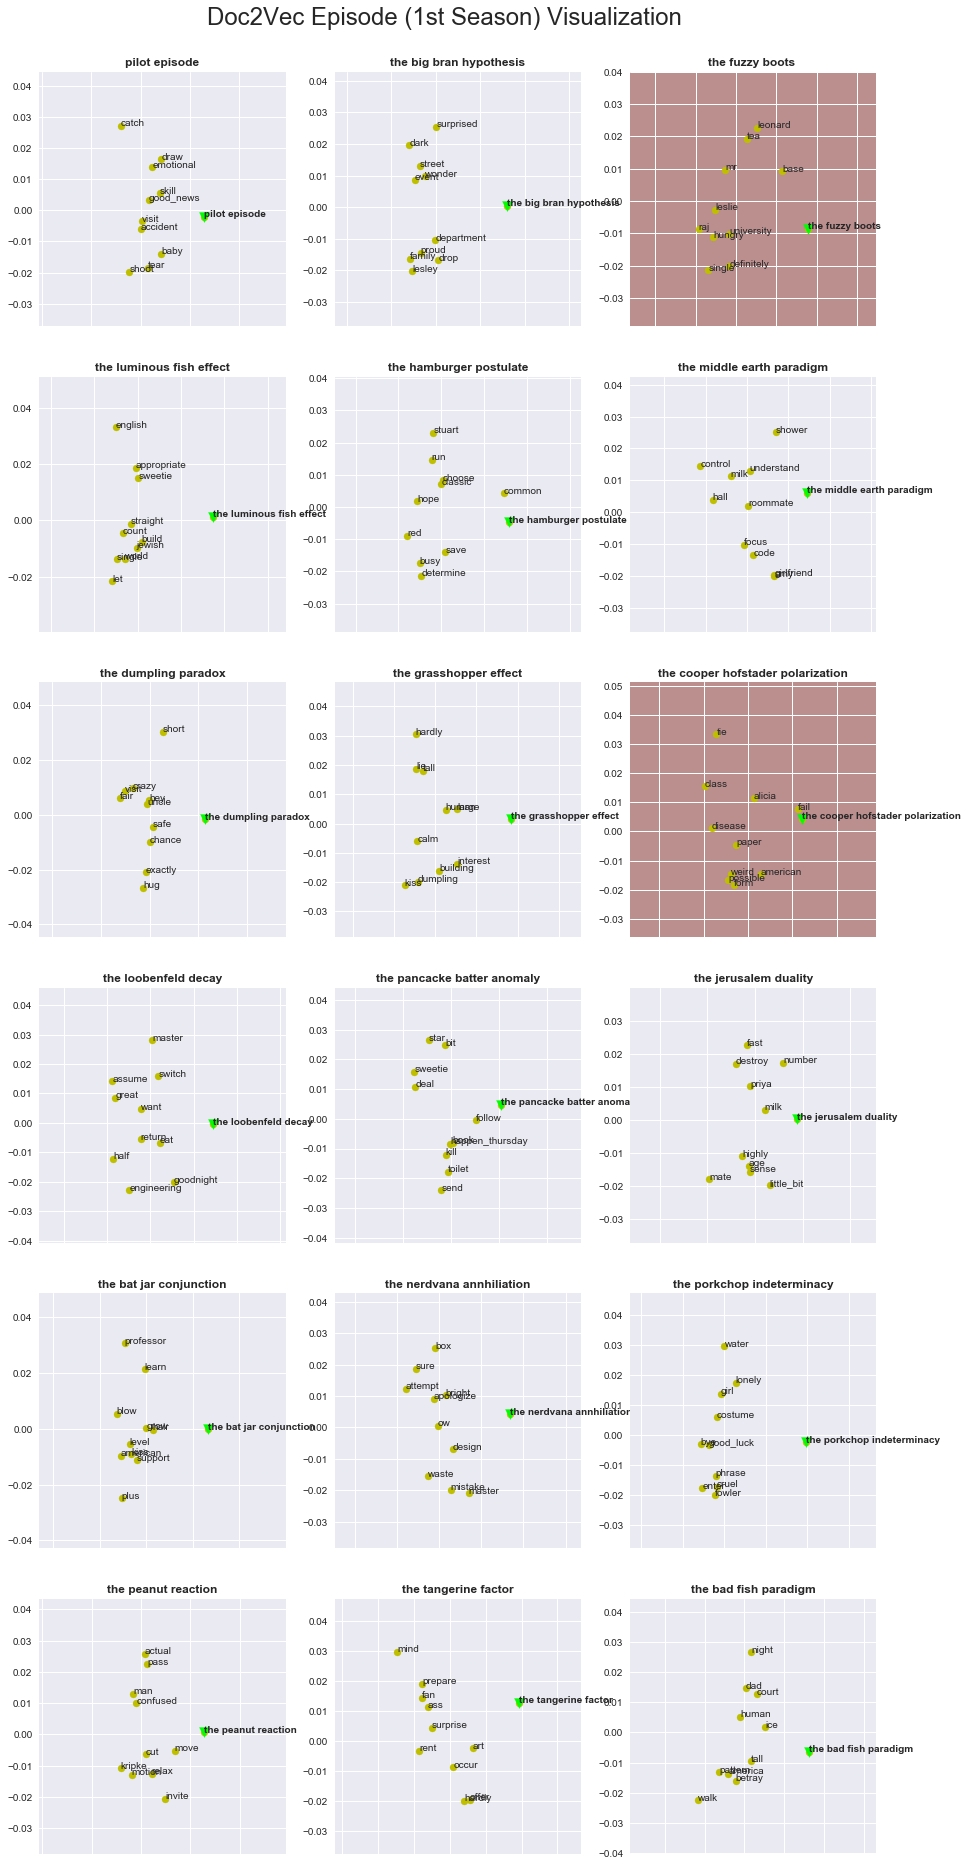

In [53]:
#only the first season will be visualized and commented
plt.style.use('seaborn')
n_row = 6
n_column = 3
fig, ax = plt.subplots(n_row,n_column, facecolor='w', figsize=(15,30))
fig.suptitle('Doc2Vec Episode (1st Season) Visualization', fontsize=24)
fig.subplots_adjust(top=0.95)
list_episode = df_train.title_episode.unique().tolist()

for row in range(n_row):
    for column in range(n_column):
        similar_words=d2v_model.wv.most_similar([d2v_model.docvecs[list_episode[row*n_column+column]]])
        words = [word for word, score in similar_words] 
        #+ [list_episode[row*4+column+1]]
        vectors = np.concatenate((d2v_model.wv[words], [d2v_model.docvecs[list_episode[row*n_column+column]]] ))

        U = svd.fit_transform(vectors)

        ax[row,column].scatter(U[:,0], U[:,1],marker='o',color='y')
        for i in range(10):
            ax[row, column].annotate(words[i], (U[i,0], U[i,1]))
        if row*n_column+column in [2,8]:
            ax[row, column].set_facecolor("rosybrown")
        ax[row, column].scatter(U[10,0], U[10,1],marker='v',color='lime',s=100)
        ax[row, column].annotate(list_episode[row*n_column+column], (U[10,0], U[10,1]),weight='bold')
        ax[row, column].set_title(list_episode[row*n_column+column],weight='bold')
        ax[row, column].tick_params('both', labelbottom= False)

The results, although not very clear, return some salient features of the plot in some episodes (highlithed in red).
- *The fuzzy boots*:  Leonard witnesses Penny kissing another man (which makes him fall into depression) and consequently she decides to invite one of her university colleagues, Leslie, since they are both single ("university","leslie","leonard","single").
- *The Cooper Hofstader polarization*: Sheldon and Leonard are invited to present their joint research "paper" at an academic conference. Sheldon forbids Leonard from presenting, which results in a fight between them. This made them "failing" the presentation and producing an embarrassing viral video ("weird", "american").

#### Extra Clustering

In [86]:
#visualization function
def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('afmhot') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=1, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
#     plt.legend()
    plt.show()

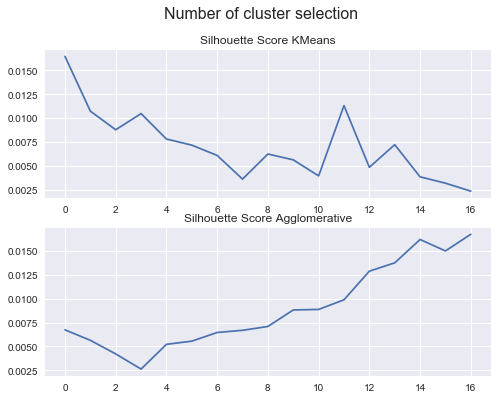

In [87]:
svd = TruncatedSVD(n_components=2)
lines = df_train.clean_line.str.lower().tolist()
tags = df_train.title_episode.tolist()

tagged_lines = []
for docids , line in enumerate(lines):
    tagged_lines.append(TaggedDocument( line.split(), [tags[docids]] ))

d2v_model = Doc2Vec(vector_size=100, 
                    window=15,
                    hs=0,
                    sample=0.000001,
                    negative=5,
                    min_count=0,
                    workers=-1,
                    epochs=50,
                    dm=0, 
                    dbow_words=1)

d2v_model.build_vocab(tagged_lines)
d2v_model.train(tagged_lines, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
doc_vectors = [d2v_model.docvecs[episode] for episode in df_train.title_episode.unique().tolist()]

score_km = []
score_agg = []

for k in range(3, 20):    
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100)
    agg = AgglomerativeClustering(n_clusters=k, linkage = 'complete') 
    X = km.fit(doc_vectors)
    X = agg.fit(doc_vectors)
    labels_km=km.labels_.tolist() 
    labels_agg=agg.labels_.tolist()    
    score_km.append(silhouette_score(doc_vectors, labels_km))
    score_agg.append(silhouette_score(doc_vectors, labels_agg))
plt.style.use('seaborn')
fig, ax = plt.subplots(2,1, facecolor='w', figsize=(8,6))
fig.suptitle('Number of cluster selection', fontsize=16)
ax[1].set_title('Silhouette Score Agglomerative')
ax[0].set_title('Silhouette Score KMeans')
ax[0].plot(score_km)
ax[1].plot(score_agg);

In [88]:
best_km = 11 #2 is too low to produce significant result
best_agg = 16

In [89]:
doc_vectors = [d2v_model.docvecs[episode] for episode in df_train.title_episode.unique().tolist()]

In [90]:
km = KMeans(n_clusters=best_km, init='k-means++', max_iter=100)
X = km.fit(doc_vectors)
labels = km.labels_.tolist()
svd = TruncatedSVD(n_components=2)
U = svd.fit_transform(doc_vectors)

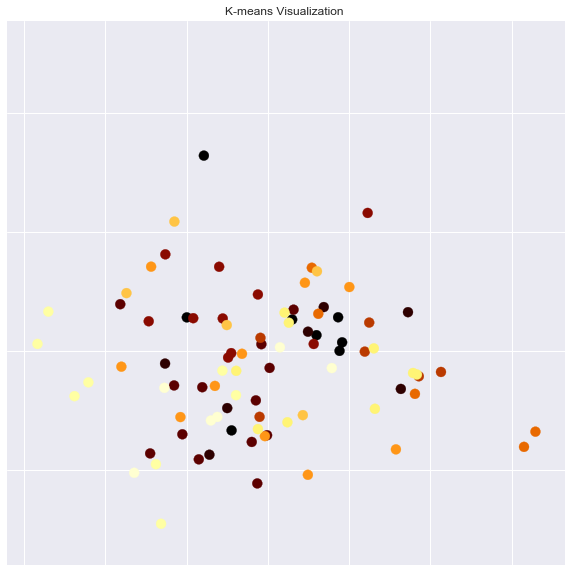

In [91]:
plot_vectors(U, title = 'K-means Visualization ', labels=labels, dimensions=2)

In [92]:
agg = AgglomerativeClustering(n_clusters=k, linkage = 'complete') 
X = agg.fit(doc_vectors)
labels_agg=agg.labels_.tolist()
svd = TruncatedSVD(n_components=2)
U = svd.fit_transform(doc_vectors)

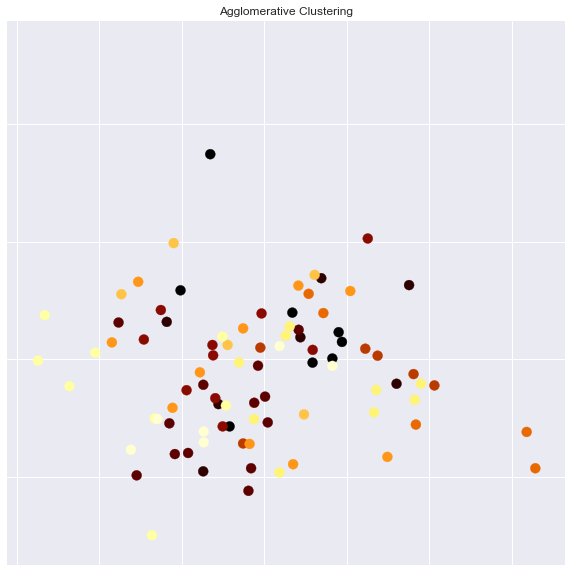

In [93]:
plot_vectors(U, title = 'Agglomerative Clustering', labels=labels, dimensions=2)

From the graphs the two episodes clustering does not seem to return well defined compartments. This may lead us to think that the little variability of spoken language covers the main themes of each episode. Ultimately, in light of the results, it seems that the dialogues do not lend themselves particularly to this type of analysis, both for the reduced length of the texts and for the fact that lines lose part of the information when they are analyzed individually.

## 4. Prediction (15 pts)

### 4.1 Classification (9 pts)
Build a predictive model of the target label and use appropriate performance metrics. Your predictive analysis needs to involve **all** of the following, summarized in a table:

1. a most-frequent-label baseline (1 point)
2. a `LogisticRegression()` baseline with default parameters and 2-6 gram character TFIDF features (1 pt)
3. the performance of **at least** two more predictive model architecture (2 pts each), including description/justification of the optmization steps taken (2 pts).
4. two bootstrap sampling significance tests of the performance difference between your best model and each of the two baselines (1 pts)

NB: Do make sure that the optimization steps are done on the development split and do *not* include the test split! Training on the test set will be graded 0!

In this part of the report we tried to classify the 5 most important characters of The Big Bang Theory (Sheldon, Leonard, Penny, Howard and Raj) to discover if there are sensible differences between them.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
nlp = spacy.load('en',disable=['parser','ner'])

from scipy.stats import ks_2samp, norm,t

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

To perform this analysis we used a harder pre-processing in order to remove the noise, which is a key issue with dialogues, by keeping only nouns and adjectives. We found that this significantly improved performance.

In [ ]:
df=pd.read_csv('bbt_12345.csv').dropna()
df['clean_line']=[(" ").join([str(token.lemma_)  for token in nlp(sentence) if token.text!=',' and token.text!='' and token.lemma_!='-PRON-' and token.pos_ in {'NOUN','ADJ'}]) for sentence in df.line]
df=df[df.character.isin(['Sheldon','Howard','Penny','Leonard','Raj'])]
df=df[(df['clean_line'].apply(len))>10]
df.shape

(9563, 7)

In [ ]:
df_train_dev=df[df['season']!=5][['season','character','clean_line']]
np.random.seed(300)
df_train, df_dev = train_test_split(df_train_dev, test_size = round(df_train_dev.shape[0]*0.3))
df_test=df[df['season']==5][['season','character','clean_line']]
print(df_train.shape,df_dev.shape,df_test.shape)

(5419, 3) (2323, 3) (1821, 3)


**Exploratory Analysis**

By looking at the distribution of the lines we noticed that the most common label is Sheldon followed by Leonard in all the first four seasons. We do not check the test set, in order to approach it in a completely unbiased way, but we have no reason to expect the situation to be significantly different. 

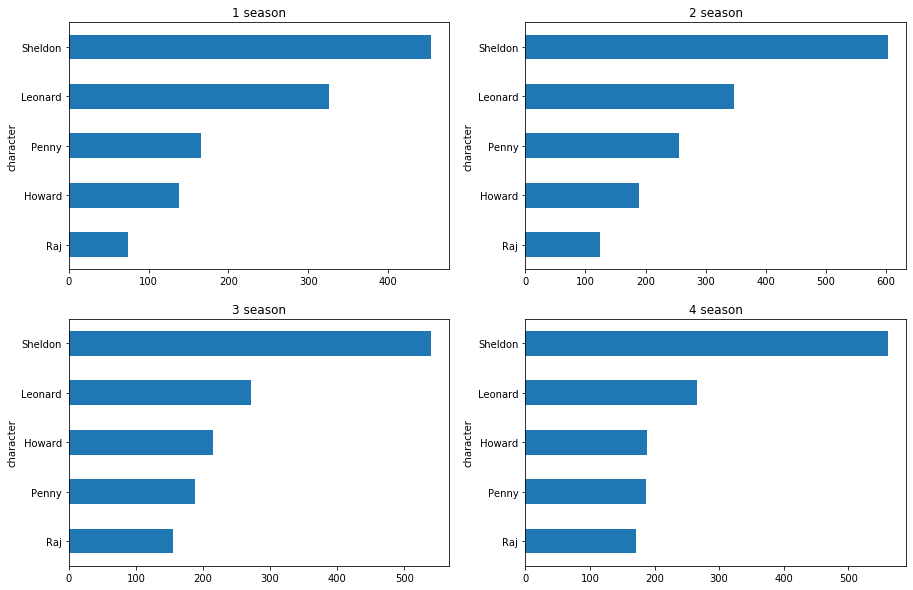

In [ ]:
#training set 

fig, ax = plt.subplots(2,2, facecolor='w', figsize=(15,10))
for i in range(2):
    for j in range(2):
        (df_train[df_train['season']==2*i+j+1]).groupby('character')['clean_line'].count().sort_values().plot.barh(ax=ax[i,j]);
        ax[i,j].set_title(str(2*i+j+1)+' season')

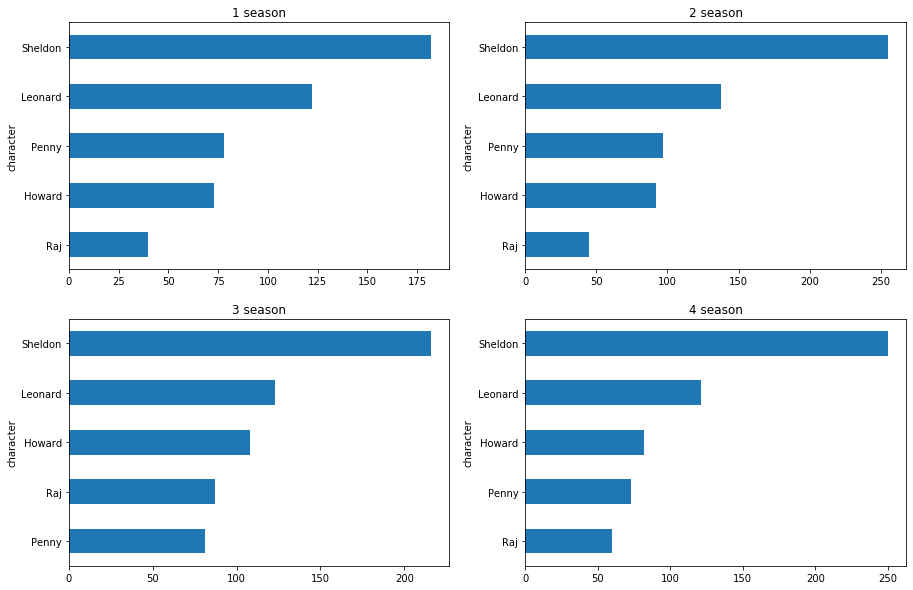

In [ ]:
#validation set

fig, ax = plt.subplots(2,2, facecolor='w', figsize=(15,10))
for i in range(2):
    for j in range(2):
        (df_dev[df_dev['season']==2*i+j+1]).groupby('character')['clean_line'].count().sort_values().plot.barh(ax=ax[i,j]);
        ax[i,j].set_title(str(2*i+j+1)+' season')

***Dataset creation***

In [ ]:
labels2numbers = LabelEncoder()

y_train = labels2numbers.fit_transform(df_train['character'])
y_dev = labels2numbers.transform(df_dev['character'])
y_test = labels2numbers.transform(df_test['character'])

In [ ]:
{labels2numbers.inverse_transform([i])[0]:i for i in range(5)}

{'Howard': 0, 'Leonard': 1, 'Penny': 2, 'Raj': 3, 'Sheldon': 4}

In [ ]:
X_train=df_train['clean_line']
X_dev=df_dev['clean_line']
X_test=df_test['clean_line']

#### ***Modelling***

In this classification setting we decided to measure the performance of each model by the weighted $f1$ score on the development set in order to take into account the different support per character.

***4.1.1. Most-frequent Label Baseline***

In [ ]:
most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_train, y_train)
predictions = most_frequent.predict(X_dev)

print(classification_report(y_dev, predictions,zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       355
           1       0.00      0.00      0.00       504
           2       0.00      0.00      0.00       329
           3       0.00      0.00      0.00       232
           4       0.39      1.00      0.56       903

    accuracy                           0.39      2323
   macro avg       0.08      0.20      0.11      2323
weighted avg       0.15      0.39      0.22      2323



***4.1.2. Logistic Regression with TFIDF - ngram(2,6)***

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2,6), min_df=2, max_df=0.7, analyzer='word',stop_words='english')

X_train0 = vectorizer.fit_transform(df_train['clean_line'])
X_dev0 = vectorizer.transform(df_dev['clean_line'])
X_test0 = vectorizer.transform(df_test['clean_line'])

print(X_train0.shape,X_dev0.shape,X_test0.shape)

(5419, 1893) (2323, 1893) (1821, 1893)


In [ ]:
pd.DataFrame(data={'ngram': vectorizer.get_feature_names(),
                'tfidf ': X_train0.sum(axis=0).A1}).sort_values('tfidf ',ascending=False).reset_index(drop=True).head()

,ngram,tfidf
0,time machine,25.271283
1,comic book,23.156257
2,penny penny,21.329838
3,good night,16.391458
4,big deal,14.999563


In [ ]:
logit= LogisticRegression(n_jobs=-1,solver='lbfgs')
logit.fit(X_train0, y_train)
predictions = logit.predict(X_dev0)
print(classification_report(y_dev,predictions))

              precision    recall  f1-score   support

           0       0.10      0.00      0.01       355
           1       0.32      0.06      0.10       504
           2       0.41      0.05      0.09       329
           3       0.00      0.00      0.00       232
           4       0.40      0.97      0.57       903

    accuracy                           0.40      2323
   macro avg       0.25      0.22      0.15      2323
weighted avg       0.30      0.40      0.26      2323



Here we can see the 5 n-grams that increase more the probability of a character to be predicted.

We can recognize some remarkable n-grams like "kitty little ball fur" that is a piece of the lullaby sung by Penny to Shelson in some of the most famous scenes of the show. Also "comic feeble attempt humour" is Leonard teasing Sheldon about having no sense of humour.

In [ ]:
character_dict={}
var=pd.DataFrame(data=logit.coef_.reshape(X_train0.shape[1],5),index=vectorizer.get_feature_names(),columns=labels2numbers.inverse_transform([0,1,2,3,4]))
for i in labels2numbers.inverse_transform([0,1,2,3,4]):
    var.sort_values(by=i,ascending=False,inplace=True)
    character_dict[i]=list(var.index[:5])
pd.DataFrame(character_dict)

,Howard,Leonard,Penny,Raj,Sheldon
0,interactive comment section,comic feeble attempt humour,rabbit hole land madness account,night evening courtesy cent margarita,tree cricket
1,online debate chatroom help,people good,kitty little ball fur,good evening,bald spot
2,poor guy,vintage video,land madness account,hole land madness account,broccoli lobster sauce vegetable
3,mean street,future mother child,baby anthropomorphized pet funny page,fa la la,portion evening
4,idea relativity,big picture,big whoop,movie minute,sex right


#### ***4.1.3. Improving on the baseline***

In our opinion a different TFIDF with ngram(1,3) could improve the prediction by capturing also some specific unigrams of the characters 

***Logistic Regression with TFIDF - ngrams(1-3) with features selection***

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=0.001, max_df=0.5, analyzer='word',stop_words='english')

X_train = vectorizer.fit_transform(df_train['clean_line'])
X_dev = vectorizer.transform(df_dev['clean_line'])
X_test = vectorizer.transform(df_test['clean_line'])

print(X_train.shape,X_dev.shape,X_test.shape)

(5419, 853) (2323, 853) (1821, 853)


In [ ]:
pd.DataFrame(data={'ngram': vectorizer.get_feature_names(),
                            'tfidf ': X_train.sum(axis=0).A1}).sort_values('tfidf ',ascending=False).reset_index(drop=True).head(10)

,ngram,tfidf
0,good,117.314072
1,penny,112.720224
2,little,97.943083
3,time,93.795948
4,friend,78.454374
5,thing,72.809520
6,guy,70.083406
7,night,67.301438
8,people,59.723574
9,right,56.450645


In [ ]:
for i in range(100,800,100):
    selector = SelectKBest(chi2, k=i)
    X_train_sel = selector.fit_transform(X_train, y_train)
    X_dev_sel = selector.transform(X_dev)
    
    classifier_sel = LogisticRegression(n_jobs=-1, solver='lbfgs',class_weight='balanced')
    classifier_sel.fit(X_train_sel, y_train)
    predictions_sel = classifier_sel.predict(X_dev_sel)
    print(i)
    print(classification_report(y_dev, predictions_sel))

100
              precision    recall  f1-score   support

           0       0.28      0.14      0.18       355
           1       0.30      0.06      0.10       504
           2       0.30      0.30      0.30       329
           3       0.33      0.18      0.23       232
           4       0.45      0.80      0.58       903

    accuracy                           0.41      2323
   macro avg       0.33      0.30      0.28      2323
weighted avg       0.36      0.41      0.34      2323

200
              precision    recall  f1-score   support

           0       0.27      0.15      0.19       355
           1       0.29      0.08      0.12       504
           2       0.28      0.32      0.29       329
           3       0.24      0.21      0.22       232
           4       0.47      0.74      0.58       903

    accuracy                           0.39      2323
   macro avg       0.31      0.30      0.28      2323
weighted avg       0.35      0.39      0.34      2323

300
          

The best model is with 600 features.

In [ ]:
selector = SelectKBest(chi2, k=600)
X_train_sel = selector.fit_transform(X_train, y_train)
X_dev_sel = selector.transform(X_dev)
classifier_sel = LogisticRegression(n_jobs=-1, solver='lbfgs',class_weight='balanced')
classifier_sel.fit(X_train_sel, y_train)
predictions_sel = classifier_sel.predict(X_dev_sel)
print(classification_report(y_dev, predictions_sel))

              precision    recall  f1-score   support

           0       0.23      0.22      0.22       355
           1       0.33      0.22      0.27       504
           2       0.27      0.37      0.31       329
           3       0.23      0.25      0.24       232
           4       0.53      0.56      0.54       903

    accuracy                           0.37      2323
   macro avg       0.32      0.32      0.32      2323
weighted avg       0.37      0.37      0.37      2323



Performance compared to the logistic baseline has increased significantly.
Also here we can recognize some relevant ngrams for the characters:
- insect: one of the fears of Raj;
- sarcasm: Penny needs to specify to Sheldon when she is joking by using this word;
- time machine: this is the theme of an episode of the first season.

In [ ]:
character_dict={}
var=pd.DataFrame(data=classifier_sel.coef_.reshape(600,5),index=np.array(vectorizer.get_feature_names())[(np.where(selector.get_support())[0]).astype(int)],columns=labels2numbers.inverse_transform([0,1,2,3,4]))
for i in labels2numbers.inverse_transform([0,1,2,3,4]):
    var.sort_values(by=i,ascending=False,inplace=True)
    character_dict[i]=list(var.index[:5])
pd.DataFrame(character_dict)

,Howard,Leonard,Penny,Raj,Sheldon
0,pro,wild,online,business,low
1,guilty,mother,sarcasm,true,motion
2,little ball,bar,okay,insect,card
3,master,time machine,familiar,loud,buddy
4,mouth,stranger,insane,choice,nature


***Linear Discriminant Analysis***

LDA with uniform distribution as a prior

In [ ]:
lda = LinearDiscriminantAnalysis(priors=[0.2,0.2,0.2,0.2,0.2])
lda.fit(X_train.toarray(), y_train)
predictions = lda.predict(X_dev.toarray())
print(classification_report(y_dev,predictions))

              precision    recall  f1-score   support

           0       0.21      0.21      0.21       355
           1       0.25      0.36      0.29       504
           2       0.27      0.35      0.30       329
           3       0.23      0.25      0.24       232
           4       0.57      0.36      0.44       903

    accuracy                           0.32      2323
   macro avg       0.31      0.31      0.30      2323
weighted avg       0.37      0.32      0.33      2323



Using the training frequencies as priors

In [ ]:
priors=list((df_train.groupby('character')['season'].count()/df_train.shape[0]).to_dict().values())
lda = LinearDiscriminantAnalysis(priors=priors)
lda.fit(X_train.toarray(), y_train)
predictions = lda.predict(X_dev.toarray())
print(classification_report(y_dev,predictions))

              precision    recall  f1-score   support

           0       0.22      0.15      0.18       355
           1       0.31      0.30      0.30       504
           2       0.33      0.31      0.32       329
           3       0.27      0.19      0.23       232
           4       0.50      0.61      0.55       903

    accuracy                           0.39      2323
   macro avg       0.32      0.31      0.31      2323
weighted avg       0.37      0.39      0.37      2323



In this case we got the same $f1$ score but an higher accuracy, so we considered this LDA the best among the linear models we tried so far.

In [ ]:
character_dict={}
var=pd.DataFrame(data=lda.coef_.reshape(X_dev.shape[1],5),index=vectorizer.get_feature_names(),columns=labels2numbers.inverse_transform([0,1,2,3,4]))
for i in labels2numbers.inverse_transform([0,1,2,3,4]):
    var.sort_values(by=i,ascending=False,inplace=True)
    character_dict[i]=list(var.index[:5])
pd.DataFrame(character_dict)

,Howard,Leonard,Penny,Raj,Sheldon
0,joke,way,alien,penny,scientific
1,section,everybody,reason,road,insane
2,classic,bathroom,paradigm,ball,restaurant
3,past,real,moon,object,man
4,brilliant,result,product,note,middle


#### ***Exploiting non-linear and non-parametric methods***

***Quadratic Discriminant Analysis***

In [ ]:
qda = QuadraticDiscriminantAnalysis(priors)
qda.fit(X_train.toarray(), y_train)
predictions = qda.predict(X_dev.toarray())
print(classification_report(y_dev,predictions))

C:\Users\acer\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              precision    recall  f1-score   support

           0       0.23      0.14      0.18       355
           1       0.25      0.00      0.01       504
           2       0.19      0.72      0.30       329
           3       0.23      0.11      0.15       232
           4       0.54      0.43      0.48       903

    accuracy                           0.30      2323
   macro avg       0.29      0.28      0.22      2323
weighted avg       0.35      0.30      0.27      2323



***Supported Vector Classifier***

Trying different cost functions.

In [ ]:
for i in [1,5,10,15]:
    svc = SVC(kernel='rbf',C=i)
    svc.fit(X_train, y_train)
    predictions = svc.predict(X_dev)
    print(i)
    print(classification_report(y_dev,predictions))

1
              precision    recall  f1-score   support

           0       0.31      0.07      0.12       355
           1       0.37      0.25      0.30       504
           2       0.43      0.21      0.28       329
           3       0.59      0.06      0.10       232
           4       0.47      0.89      0.61       903

    accuracy                           0.45      2323
   macro avg       0.43      0.30      0.28      2323
weighted avg       0.43      0.45      0.37      2323

5
              precision    recall  f1-score   support

           0       0.24      0.15      0.19       355
           1       0.33      0.31      0.32       504
           2       0.35      0.31      0.33       329
           3       0.28      0.09      0.14       232
           4       0.50      0.70      0.58       903

    accuracy                           0.42      2323
   macro avg       0.34      0.31      0.31      2323
weighted avg       0.38      0.42      0.39      2323

10
              p

The best cost function is:

In [ ]:
svc = SVC(kernel='rbf',C=5)
svc.fit(X_train, y_train)
predictions = svc.predict(X_dev)
print(classification_report(y_dev,predictions))

              precision    recall  f1-score   support

           0       0.24      0.15      0.19       355
           1       0.33      0.31      0.32       504
           2       0.35      0.31      0.33       329
           3       0.28      0.09      0.14       232
           4       0.50      0.70      0.58       903

    accuracy                           0.42      2323
   macro avg       0.34      0.31      0.31      2323
weighted avg       0.38      0.42      0.39      2323



Unfortunately with non-linear models we lose interpretability of the parameters, although performance measured by f1 score has increased.

***Decision Tree Boosting***

In [ ]:
for i in range(100,1000,100):
    boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=i)
    boost.fit(X_train, y_train)
    predictions = boost.predict(X_dev)
    print(i)
    print(classification_report(y_dev,predictions))

              precision    recall  f1-score   support

           0       0.17      0.14      0.15       355
           1       0.31      0.24      0.27       504
           2       0.28      0.25      0.26       329
           3       0.15      0.08      0.10       232
           4       0.46      0.62      0.53       903

    accuracy                           0.36      2323
   macro avg       0.27      0.27      0.26      2323
weighted avg       0.33      0.36      0.33      2323

              precision    recall  f1-score   support

           0       0.17      0.13      0.14       355
           1       0.30      0.23      0.26       504
           2       0.25      0.23      0.24       329
           3       0.17      0.10      0.13       232
           4       0.46      0.62      0.53       903

    accuracy                           0.35      2323
   macro avg       0.27      0.26      0.26      2323
weighted avg       0.32      0.35      0.33      2323

              precisio

In [ ]:
boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=300)
boost.fit(X_train, y_train)
predictions = boost.predict(X_dev)
print(classification_report(y_dev,predictions))

              precision    recall  f1-score   support

           0       0.19      0.15      0.17       355
           1       0.27      0.29      0.28       504
           2       0.26      0.22      0.24       329
           3       0.19      0.12      0.15       232
           4       0.47      0.55      0.51       903

    accuracy                           0.35      2323
   macro avg       0.28      0.27      0.27      2323
weighted avg       0.33      0.35      0.33      2323



We can see that boosting yield much worse results compared to SVC. However, in this case we can identify the most important predictors (which do not seem particularly informative):

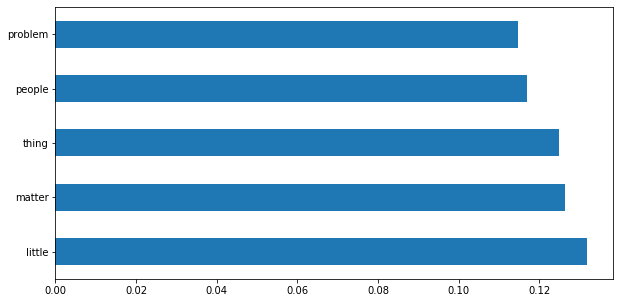

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
np.seterr(divide='ignore', invalid='ignore')
var=pd.DataFrame(data=boost.feature_importances_.reshape(X_dev.shape[1],1),index=vectorizer.get_feature_names(),columns=['feature importance']).sort_values(by='feature importance',ascending=False)
(var.head(5)['feature importance']).plot.barh(ax=ax);

#### ***4.1.4. Sampling significance tests***

***Non-parametric test***

The best model in terms of performance ended up being the Support Vector Classifier, so we compare that with the two baselines. 

In [ ]:
def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='weighted'):

    N = len(gold)
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)

    basedelta = base_score1 - base_score2

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        sample = np.random.choice(N, size=N, replace=True)

        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

In [ ]:
p_value, deltas = bootstrap_sample(svc.predict(X_dev), most_frequent.predict(X_dev0), y_dev)
print(p_value, p_value < 0.01)

0.0 True


In [ ]:
p_value, deltas = bootstrap_sample(svc.predict(X_dev), logit.predict(X_dev0), y_dev)
print(p_value, p_value < 0.01)

0.0 True


***EXTRA: Parametric test***

We decided also to perform a different significance test.

Starting from the definition of $\textit{p}-value$ in the context of hypothesis testing:
*The probability of getting a test statistic value equal or more extreme ( ≤ or ≥ ) of the value provided by the sample, assuming $H_{0}$ true*.

So for an unilateral test with the hypotheses:
<h5 align="center">$H_{0}$: $\mu\leqslant0$ vs $H_{1}$: $\mu>0$</h5>

We can define the $\textit{p}-value$ as $P\left(F>\frac{\mu-0}{\frac{\sigma}{\sqrt{n}}}\right)$\, where F represents the underlying distribution function.

In this setting, our goal is to assess that the difference between the weighted $f1$ of the SVC and the one of the logistic baseline is statistically greater than 0.
In order to do that we need to define:
- the T-statistic: we will use the ratio between the mean and the standard error of the deltas distribution;
- the density function of the deltas.

For approximating the density function we decided to use the Kolmogorov-Smirnov statistic that, for a given cumulative distribution function F(x), is:
<h5 align="center">$D_n = \sup_{x} |(F_{n}-F)|$</h5>

Ideally it should be equal to 0 for a perfect fit, so our goal will be minimize it by proposing various T-Student density functions with different degrees of freedom to approximate the real distribution function.

In [ ]:
d={}
for i in range(1,100):
    y=np.random.standard_t(i,size=1000)*np.std(deltas)+np.mean(deltas)
    d[i]=ks_2samp(y,deltas)[0]
df=min(d, key=d.get)
print('With',df,'degrees of freedom we get a Kolmogorov-Smirnov statistic',d[max(d, key=d.get)])

With 65 degrees of freedom we get a Kolmogorov-Smirnov statistic 0.149


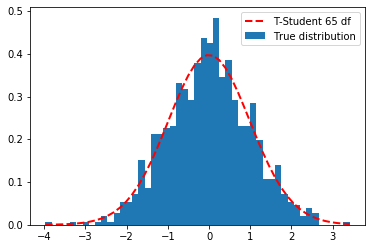

In [ ]:
%matplotlib inline
new_deltas=(pd.Series(deltas)-np.mean(deltas))/np.std(deltas)
bins=np.linspace(min(new_deltas),max(new_deltas),50)
plt.hist(new_deltas,bins=bins,density=True,label='True distribution')
y = t.pdf(x=bins,df=df)
plt.plot(bins, y, 'r--', linewidth=2,label=('T-Student '+str(df)+' df'))
plt.legend();

In [ ]:
print('With this parametric method we estimated a p-value of',1-t.cdf(np.mean(deltas)/np.std(deltas),df=df),'that is significant at every level.')

With this parametric method we estimated a p-value of 0.0 that is significant at every level.


#### ***Test performance***

Finally we fit our model on the $5^{th}$ season, our test set, showing the results with a multilabel confusion matrix.

The results show that we predict the right character almost once every 3 lines; the factors that can lead to this apparently underwhelming result can be:
- the relatively large prevalence of the lines of Sheldon;
- the fact that the characters are sharing the topics of the dialogues (and also, some of their characteristic quirks).
- the fact that many lines are generic reactions, and it is very hard to filter for "informative" lines (just number of characters is not sufficient)

Here there are the results on the test set for the best linear and non-linear model (which both beat the two baselines): Linear Discriminant Analysis and Support Vector Classifier.

***Best linear model: LDA***

In [ ]:
confusion_matrix=np.zeros((5,5))
for i in zip(y_test,lda.predict(X_test.toarray())):
    confusion_matrix[i]+=1
print('f1:',"{:.2%}".format(f1_score(y_test,lda.predict(X_test.toarray()),average='weighted')))
pd.DataFrame(data=confusion_matrix,index=['Howard_gold','Leonard_gold','Penny_gold','Raj_gold','Sheldon_gold'],columns=['Howard_predicted','Leonard_predicted','Penny_predicted','Raj_predicted','Sheldon_predicted'])

f1: 34.91%


,Howard_predicted,Leonard_predicted,Penny_predicted,Raj_predicted,Sheldon_predicted
Howard_gold,46.0,49.0,48.0,22.0,104.0
Leonard_gold,45.0,100.0,69.0,24.0,139.0
Penny_gold,32.0,59.0,72.0,17.0,76.0
Raj_gold,30.0,51.0,30.0,34.0,68.0
Sheldon_gold,67.0,141.0,60.0,39.0,399.0


***Best non linear model: SVC***

In [ ]:
confusion_matrix=np.zeros((5,5))
for i in zip(y_test,svc.predict(X_test)):
    confusion_matrix[i]+=1
print('f1:',"{:.2%}".format(f1_score(y_test,svc.predict(X_test),average='weighted')))
pd.DataFrame(data=confusion_matrix,index=['Howard_gold','Leonard_gold','Penny_gold','Raj_gold','Sheldon_gold'],columns=['Howard_predicted','Leonard_predicted','Penny_predicted','Raj_predicted','Sheldon_predicted'])

f1: 34.80%


,Howard_predicted,Leonard_predicted,Penny_predicted,Raj_predicted,Sheldon_predicted
Howard_gold,42.0,55.0,41.0,10.0,121.0
Leonard_gold,44.0,93.0,73.0,15.0,152.0
Penny_gold,32.0,54.0,67.0,16.0,87.0
Raj_gold,29.0,50.0,28.0,25.0,81.0
Sheldon_gold,65.0,126.0,51.0,23.0,441.0


Trying to predict some of the most iconic lines (from any season) with both models:

In [ ]:
instances=['She does not have a boyfriend, she has a Sheldon', #Penny line
          'Once you are fluent, you will have a billion more people to annoy instead of me', #Howard line talking with Sheldon
          'Interesting. You are afraid of insects and women. Ladybugs must render you catatonic', #Sheldon line talking with Raj
          'People get things they do not deserve all the time. Like me with you', #Leonard line talking with Sheldon
          'Oh man, first monster I see I am gonna sneak up behind him, whip out my wand and shoot my magic all over his ass'] #Raj
clean_instaces=[(" ").join([str(token.lemma_)  for token in nlp(sentence) if token.text!=',' and token.text!='' and token.lemma_!='-PRON-' and token.pos_ in {'NOUN','ADJ'}]) for sentence in instances]
x=vectorizer.transform(clean_instaces)
print('LDA')
print(labels2numbers.inverse_transform(lda.predict(x.toarray())))
print('SVC')
print(labels2numbers.inverse_transform(svc.predict(x)))

LDA
['Leonard' 'Sheldon' 'Howard' 'Penny' 'Howard']
SVC
['Penny' 'Sheldon' 'Sheldon' 'Sheldon' 'Leonard']


### 4.2 Structured Prediction (6pts)
Run the Structured Prediction model as-is on your sequence prediction task, and note the performance as baseline (1 pt).
Change the features to improve performance (2 pts).
Run a suitable neural net implementation (in `keras`) on the data and compare the best performance to the other two models (4 pts).

In [165]:
import h5py
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import random
import seaborn as sns
import sys

from collections import defaultdict
from keras import metrics
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional, Dense, Dropout, Embedding, Input, LSTM
from keras.models import Model #, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

***Dataset preparation***

First, we prepare the dataset for this analysis. We only select Sheldon's lines, but keeping the same train-dev-test split as above. Also, we reduce the dataset only including those lines that have length up to around the 90th percentile. This decision was driven by computational needs: there are a few very long lines that dramatically increased training time making it difficult to try out different architectures for long enough to be able to evaluate them properly. 

We build all of the models using the raw text and not removing punctuation. Although removing it slightly increased performance of all the models (but it did not impact relative performance!), it resulted in lower quality generated text. 

As a performance indicator we use model perplexity, calculated as $2^{H(x)}$, with $H(x)$ being the cross-entropy.
In the probabilistic model, cross-entropy was calculated manually as $H(x) = -\frac{1}{N}\sum_{i=1}^{m}log_{2}q(x_i)$, with $N$ being the total number of words in the data and $q$ the distribution induced by the model on the sentence $x_i$. Instead, in the neural network we used the cross-entropy loss $H(x) = -\sum_{x}p(x)log_{2}\hat{p}(x)$, with $p$ being the empirical distribution of the sample and $\hat{p}$ being the one estimated by the model. 

In [21]:
df = pd.read_csv('bbt_clean.csv',index_col=[0])
df = df[df.character == 'Sheldon'][['character','line','set']].drop_duplicates(subset=['line'])
len(df)

5839

In [22]:
maxlen = 30
df['over'] = 0
for i in range(len(df)):
    line = df.iloc[i,df.columns.get_loc('line')]
    if len(line.split(' ')) > maxlen:
        df.iloc[i, df.columns.get_loc('over')] = 1
df2 = df[df.over == 0]

In [23]:
train = df2[df2.set == 'train'].line.tolist()
dev = df2[df2.set == 'dev'].line.tolist()
test = df2[df2.set=='test'].line.tolist()

In [24]:
(len(train),len(dev),len(test))

(3467, 839, 902)

***Baseline: Bigram Model***

The baseline model is a probabilistic bigram model, which uses a first degree markov chain to predict the next word given the current one. The distribution is built as a nested defaultdict over the training set.

In [25]:
START = '<START>'
END = '<END>'

train_corpus = [line.strip().split() for line in train]
dev_corpus = [line.strip().split() for line in dev]
test_corpus = [line.strip().split() for line in test]

In [26]:
smoothing = 0.001

### model building

counts_bigram = defaultdict(lambda: defaultdict(lambda: smoothing))
for sentence in train_corpus:
    tokens = [START] + sentence + [END]
    for u,v in nltk.ngrams(tokens, 2):
        counts_bigram[u][v] += 1

        
### functions for model evaluation        
        
def logP_bigram(u, v):
    '''
    compute the log probability of a bigram
    '''
    
    return np.log(counts_bigram[u][v]) - np.log(sum(counts_bigram[u].values()))


def sentence_logP_bigram(S):
    '''
    score a sentence in log likelihood
    '''
    
    tokens = [START] + S + [END]
    return sum([logP_bigram(u, v) for u, v in nltk.ngrams(tokens, 2)])


def cross_entropy_perplexity_bigram(corpus):
    '''
    calculate model perplexity, given a corpus
    '''
    cross_entropy = 0
    words = 0
    for sentence in corpus:
        cross_entropy += sentence_logP_bigram(sentence)
        words += len(sentence)
    ppl = 2 ** (-cross_entropy/words)
    return ppl


### functions for text generation

def bigram_sample(u):
    '''
    sample a word v based on the the previous word u
    '''
    keys, values = zip(*counts_bigram[u].items())
    
    values = np.array(values)
    values /= values.sum() 
    
    sample = np.random.multinomial(1, values) 
    
    return keys[np.argmax(sample)] 


def bigram_generate(initial='',START=START,END=END):
    '''
    generate a line
    '''
    result = [START] + initial.split()
    next_word = ''
    while next_word != END:
        next_word = bigram_sample(result[-1])
        result.append(next_word)
    
    return ' '.join(result[1:-1])

In [27]:
## performance: 

print(cross_entropy_perplexity_bigram(train_corpus))
print('')
print(cross_entropy_perplexity_bigram(dev_corpus))

8.351117195120512

79.56602723217922


In [28]:
bigram_generate('I am')

'I am quite close to know that measuring cup of commitment to make it, it’s not to have sex with.'

In [148]:
bigram_generate()

'No, no, nothing to the box, and Penny. You had a facebook page, an energy storage capacity of a man walking!'

Perplexity is quite high, also on the training set, and immediately we can see that the generated sentences make absolutely no sense. Using a bigram model is indeed very restrictive: there is no context on which the generation can be based.

***Baseline improvement: Trigram Model***

To improve the baseline, we turn the first degree chain into a second degree one and predict the next word by using the two preceding ones. In general, trigram models are usually very performant so we expect to get good results on short texts like these.  Again, we use a nested defaultdict. 

In [112]:
### building the model

smoothing = 0.001

counts_trigram = defaultdict(lambda: defaultdict(lambda: smoothing))

for sentence in train_corpus:
    tokens = [START,START] + sentence + [END]
    for u, v, w in nltk.ngrams(tokens, 3):
        counts_trigram[(u, v)][w] += 1
        
        
### functions for model evaluation

def logP_trigram(u, v, w):
    '''
    compute the log probability of a trigram
    '''
    
    return np.log(counts_trigram[(u, v)][w]) - np.log(sum(counts_trigram[(u, v)].values()))


def sentence_logP_trigram(S):
    '''
    score a sentence in log likelihood
    '''
    
    tokens = [START, START] + S + [END]
    return sum([logP_trigram(u, v, w) for u, v, w in nltk.ngrams(tokens, 3)])
    

def cross_entropy_perplexity_trigram(corpus):
    '''
    calculate model perplexity, given a corpus
    '''
    cross_entropy = 0
    words = 0
    for sentence in corpus:
        cross_entropy += sentence_logP_trigram(sentence)
        words += len(sentence)
    ppl = 2 ** (-cross_entropy/words)
    return ppl


### functions for text generation

def trigram_sample(u, v):
    '''
    sample a word w based on the history (u,v)
    '''
    keys, values = zip(*counts_trigram[(u, v)].items())
    
    values = np.array(values)
    values /= values.sum() 
    
    sample = np.random.multinomial(1, values) 
    
    return keys[np.argmax(sample)] 


def trigram_generate(initial='',START=START,END=END):
    '''
    generate a line
    '''
    result = [START,START] + initial.split()
    next_word = trigram_sample(result[-2], result[-1])
    result.append(next_word)
    while next_word != END:
        next_word = trigram_sample(result[-2], result[-1])
        result.append(next_word)
    
    return ' '.join(result[2:-1])

In [113]:
## evaluation

print(cross_entropy_perplexity_trigram(train_corpus))
print('')
print(cross_entropy_perplexity_trigram(dev_corpus))

2.272351943597361

8.955677234312002


In [121]:
trigram_generate('I')

'I looked over the place this morning. I have your kite. I have to, the dates just happened to you?'

In [126]:
trigram_generate('Hi,')

'Hi, Stephanie. I’m sorry this really isn’t my strong suit.'

In [118]:
trigram_generate()

'So what time it is?'

Since the second model clearly outperforms the first on both train and development sets, we collect the perplexity measures to compare with the neural model. 

Also, we can see that the generated lines usually tend to make pretty good sense. At a closer inspection, however, we can notice that the model mixes and matches existing pieces of sentences (which sometimes leads to remarkably good results). With a neural network, the hope is to be able to generate more original but still meaningful lines by exploiting the embedding layer. 

In [36]:
trigram_ppl_dev = cross_entropy_perplexity_trigram(dev_corpus)
trigram_ppl_train = cross_entropy_perplexity_trigram(train_corpus)
trigram_ppl_test = cross_entropy_perplexity_trigram(test_corpus)

***Neural Network Implementation: Bidirectional LSTM***

Our neural network implementation of the language model is a bidirectional single-layer LSTM, which takes as input sequences of n=6 tokens and as labels a another sequence of n tokens but shifted. Longer sequences dramatically increased training time and caused a tendency to overfit. We add a $<start>$ and $<end>$ token to hopefully be able to generate self-contained lines without the need to explicitly specify the number of words that we want. We add a step between each sample that we produce of k=2 tokens. This was again to avoid overfitting (the main issue, with most of the implementations we tried). Making the LSTM bidirectional was extremely valuable to improve the fit of the model on both train and development set.
    
Another promising, albeit a bit unorthodox, approach was to predict the next single word given a sequence of n preceding words (of variable length, going from 1 to len(sentence) - 1). This increased both training epochs and number of samples dramatically (aroung 4x the current number), making the process prohibitive to handle on a laptop and very time consuming. Achieving a good balance between performance and parsimony/trainability was key for us. 

In [37]:
train_bounded = ['<start> ' + i + ' <end>' for i in train]
dev_bounded = ['<start> ' + i + ' <end>' for i in dev]
test_bounded = ['<start> ' + i + ' <end>' for i in test]

In [38]:
filters = ''
#We keep all punctuation as is, in order to make a totally fair comparison with the baseline model.

tokenizer = Tokenizer(filters=filters,oov_token='<unk>')
tokenizer.fit_on_texts(train_bounded) #only fitting the tokenizer on the training set
num_words = len(tokenizer.word_index)  + 1

In [39]:
num_words #number of possible labels

8838

In [40]:
#creating sequences
ngram_range = 6
steps = 2

def get_token_sequences(corpus, tokenizer, ngram_range,steps):
    
    token_sequences = []
    label_sequences = []
    for doc in corpus:
        doc_tokens = tokenizer.texts_to_sequences([doc])[0]
    
        for i in range(1, len(doc_tokens)-1,steps):
            ngram_seq = doc_tokens[i:i+ngram_range]
            label_seq = doc_tokens[i+1:i+ngram_range+1]
            token_sequences.append(ngram_seq)
            label_sequences.append(label_seq)
    return token_sequences,label_sequences

In [41]:
#creating predictors and labels:

train_tokens, train_labels = get_token_sequences(train_bounded,tokenizer,ngram_range,steps)
dev_tokens, dev_labels = get_token_sequences(dev_bounded,tokenizer,ngram_range,steps)
test_tokens,test_labels = get_token_sequences(test_bounded,tokenizer,ngram_range,steps)

In [42]:
print(train_bounded[1])
print(train_tokens[1:3])
print(train_labels[1:3])
print(len(train_tokens))

<start> What’s the protocol for leaving? <end>
[[141, 4, 592, 18, 2904, 3], [592, 18, 2904, 3]]
[[4, 592, 18, 2904, 3], [18, 2904, 3]]
20076


In [43]:
#padding sequences for training and development sets

maxlen = ngram_range

train_tokens = pad_sequences(train_tokens, maxlen=maxlen, padding='post')
dev_tokens = pad_sequences(dev_tokens, maxlen=maxlen, padding='post')
train_labels = pad_sequences(train_labels, maxlen=maxlen, padding='post')
dev_labels = pad_sequences(dev_labels, maxlen=maxlen, padding='post')

In [44]:
print(train_tokens[1:3])
print(train_labels[1:3])

[[ 141    4  592   18 2904    3]
 [ 592   18 2904    3    0    0]]
[[   4  592   18 2904    3    0]
 [  18 2904    3    0    0    0]]


In [45]:
#one-hot encode the labels

train_labels_1hot = to_categorical(train_labels, num_classes=num_words)
dev_labels_1hot = to_categorical(dev_labels, num_classes=num_words)

In [46]:
train_labels_1hot.shape

(20076, 6, 8838)

In [47]:
train_labels_1hot[0].shape

(6, 8838)

In [48]:
print(train_labels[0])
print('')
print(train_labels_1hot[0])

[2903    3    0    0    0    0]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [49]:
#defining the model:

input_len = maxlen 

np.random.seed(0)

inputs = Input((maxlen,), 
               name='token_sequences')

embeddings = Embedding(num_words,
                       output_dim=100, 
                       input_length = maxlen,
                      mask_zero = True,
                      name='embeddings')(inputs)

lstm = Bidirectional(LSTM(100, return_sequences=True), name='LSTM')(embeddings) #bidirectional is key 

dropout = Dropout(0.5, name='dropout')(lstm) #high dropout rate very helpful to prevent overfitting

output = Dense(num_words, activation='softmax', name='output')(dropout) 

model = Model(inputs=[inputs], outputs=[output])

model.summary()

#number of parameters high, but more parsimonious approaches did not yield comparable results.
#in general, the aim was to be as parsimonious as possible (with high dropout and an early stopping condition)
#while still trying to achieve the best performance we could, using the trigram model as the baseline to beat. 

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
token_sequences (InputLayer) (None, 6)                 0         
_________________________________________________________________
embeddings (Embedding)       (None, 6, 100)            883800    
_________________________________________________________________
LSTM (Bidirectional)         (None, 6, 200)            160800    
_________________________________________________________________
dropout (Dropout)            (None, 6, 200)            0         
_________________________________________________________________
output (Dense)               (None, 6, 8838)           1776438   
Total params: 2,821,038
Trainable params: 2,821,038
Non-trainable params: 0
_________________________________________________________________


In [50]:
#we implement early stopping based on the validation cross-entropy loss

es = EarlyStopping(monitor='val_loss',min_delta=0.01,patience=2,restore_best_weights=True)

In [51]:
#training the model:

batch_size = 8 
epochs = 20 #more is not beneficial (and leads to overfitting)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=[metrics.categorical_accuracy])


bilstm_model = model.fit(train_tokens, train_labels_1hot, 
                       batch_size = batch_size, 
                       epochs=epochs, 
                       verbose=1,
                      validation_data=(dev_tokens, dev_labels_1hot),callbacks = [es])

/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20076 samples, validate on 5075 samples
Epoch 1/20
20076/20076 [==============================] - 202s 10ms/step - loss: 4.5649 - categorical_accuracy: 0.2652 - val_loss: 4.1201 - val_categorical_accuracy: 0.3840
Epoch 2/20
20076/20076 [==============================] - 211s 11ms/step - loss: 3.3932 - categorical_accuracy: 0.4448 - val_loss: 3.6917 - val_categorical_accuracy: 0.4991
Epoch 3/20
20076/20076 [==============================] - 213s 11ms/step - loss: 2.6655 - categorical_accuracy: 0.5454 - val_loss: 3.5160 - val_categorical_accuracy: 0.5629
Epoch 4/20
20076/20076 [==============================] - 218s 11ms/step - loss: 2.0381 - categorical_accuracy: 0.6253 - val_loss: 3.4725 - val_categorical_accuracy: 0.5982
Epoch 5/20
20076/20076 [==============================] - 216s 11ms/step - loss: 1.5016 - categorical_accuracy: 0.7064 - val_loss: 3.4117 - val_categorical_accuracy: 0.6188
Epoch 6/20
20076/20076 [==============================] - 216s 11ms/step - loss: 1.089

In [52]:
##saving trained model

#model.save('bilstm_model.h5')

##model can be reloaded from here (and used for prediction):

##epochs trained: 20
##final training loss: 0.1618
##final accuracy: 0.9636
##final validation loss: 3.1037 (8.5962)
##final validation accuracy: 0.6703

#model = load_model('bilstm_model.h5')

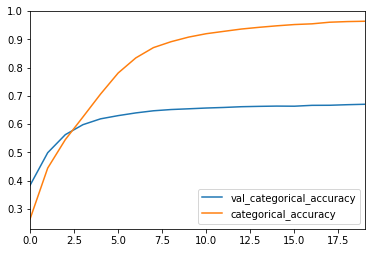

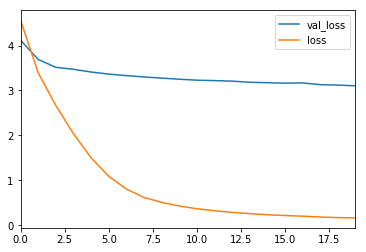

In [53]:
%matplotlib inline
df = pd.DataFrame(bilstm_model.history)
df['perplexity'] = 2 ** df.loss
df['val_perplexity'] = 2 ** df.val_loss
df[['val_categorical_accuracy', 'categorical_accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [107]:
df.tail(1)

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,perplexity,val_perplexity
19,3.103718,0.6703,0.161788,0.963641,1.118673,8.596313


Comparing the trigram model and the Bidirectional LSTM we can see that the latter has a better performance in terms of perplexity on both the training set and, most importantly, the development set. Although the difference with the trigram model is not particularly high, the LSTM again clearly beats the bigram model. 

Even matching the trigram model ended up not being trivial at all. This was not too surprising: indeed, the dataset is relatively small for a neural network implementation and the model was intentionally simplified to make it trainable on a standard laptop (and the final version that you see here barely met this condition). 

In order to improve the performance of the neural implementation, two possible choices would be then to:
1. add (a lot) more data and train for longer
2. make the model more sophisticated by adding layers, decreasing step size and/or using longer sequences, hoping that the larger dataset and more regularization can counteract the tendency to overfit.

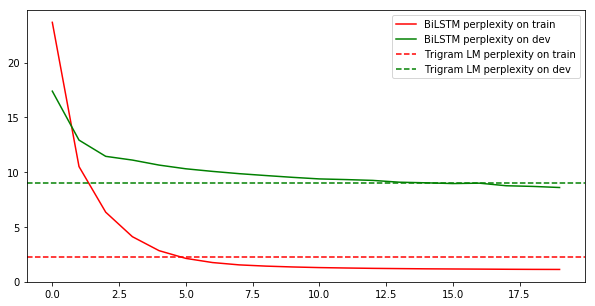

In [54]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(df.index,df.perplexity,color='r')
ax.plot(df.index,df.val_perplexity,color='g')
ax.axhline(trigram_ppl_train,color='r',ls='--')
ax.axhline(trigram_ppl_dev,color='g',ls='--')
ax.legend(['BiLSTM perplexity on train','BiLSTM perplexity on dev',
           'Trigram LM perplexity on train','Trigram LM perplexity on dev']);

In [55]:
# looking at performance on the test set:

test_tokens = pad_sequences(test_tokens, maxlen=maxlen, padding='post')
test_labels = pad_sequences(test_labels, maxlen=maxlen, padding='post')
test_labels_1hot = to_categorical(test_labels, num_classes=num_words)

In [56]:
loss, accuracy = model.evaluate(test_tokens, test_labels_1hot,batch_size=batch_size,verbose=False)

Moving onto test-set performance for the top two, we see that the results are pretty much equivalent. In this case we were very lucky: the development set is a very good approximation of the test set! 

This also suggests that Sheldon's lines over the seasons are not dramatically different (the development set is a random set across the first 4, while the test set is only made up of lines from season 5) and thus it may be possible to achieve much better results implementing the two modifications listed above. 

In [57]:
print(f'test loss: {loss}')
print(f'test categorical accuracy: {accuracy}')
print(f'test perplexity: {2 ** loss}')
print('')
print(f'trigram model test perplexity: {trigram_ppl_test}') #comparing with the trigram model 

test loss: 3.1405600791268498
test categorical accuracy: 0.6714914441108704
test perplexity: 8.818663820129508

trigram model test perplexity: 9.312579801905528


In [142]:
### function for text generation

## note: differently from the probabilistic model, this one is stable: 
# given the same input it always produces the exact same sentence

#a "probabilistic" text generation function that we also implemented (and you can find collapsed in the cell below)
#yielded mostly completely non-sensical results. 

maxlen = maxlen
ngram_range = ngram_range
def bilstm_generate(input_text='', model=model, maxlen=maxlen, ngram_range=ngram_range):
    '''
    generate text, given an input, based on the predictions of the Bi-LSTM model
    '''
    input_text = '<start> ' + input_text.capitalize()
    for i in range(20): #if it doesn't find an "<end>" token, it will go on looping if I use While True!
        tokens = tokenizer.texts_to_sequences([input_text])[0]
        l = min(len(tokens),maxlen) - 1
        tokens = pad_sequences([tokens], maxlen=maxlen, padding='post',truncating='pre')
        prediction = np.argmax(model.predict(tokens, verbose=0)[0,l,:])
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == prediction:
                if word != '<end>':
                    output_word = word
                else:
                    return input_text.split(' ',1)[1]
                    break
        input_text += " "+ output_word
    return input_text.split(' ',1)[1]

In [143]:
def bilstm_sample(input_text):
    tokens = tokenizer.texts_to_sequences([input_text])[0]
    l = min(len(tokens),maxlen) - 1
    tokens = pad_sequences([tokens], maxlen=maxlen, padding='post',truncating='pre') 
    # predicted probabilities do not sum up to 1 exactly (although the error is clearly extremely small e.g. +0.000005)
    #it is enough for numpy to generate an error message.
    preds = np.asarray(model.predict(tokens, verbose=0)[0,l,:]).astype('float64')
    probs =preds/np.sum(preds,axis=0)
    words, indices = zip(*tokenizer.word_index.items())
    sample = np.random.multinomial(1, probs)
    return words[np.argmax(sample)]

def bilstm_generate2(input_text='', model=model, maxlen=maxlen, ngram_range=ngram_range):
    input_text = '<start> ' + input_text.capitalize()
    next_word = bilstm_sample(input_text) 
    input_text += " "+ next_word 
    for i in range(30):
        word = bilstm_sample(input_text)
        if word != '<end>':
            next_word = word
        else:
            return input_text.split(' ',1)[1]
            break
        input_text += " "+ next_word
    return input_text.split(' ',1)[1]

In [163]:
# a collection of generated text:

print(bilstm_generate('Penny,'))
print(bilstm_generate('Amy'))  #the full name of Amy
print(bilstm_generate('Amy was')) #which, if you have watched the show.. is not totally wrong :) 
print(bilstm_generate("go"))
print(bilstm_generate('You think'))
print(bilstm_generate('This'))
print(bilstm_generate('I know'))
print(bilstm_generate('did'))
print(bilstm_generate('he does'))
print(bilstm_generate('we have'))
print(bilstm_generate('I had'))
print(bilstm_generate('Oh,'))
print(bilstm_generate('Well,'))

Penny, i was working knowledge of the the american education system.
Amy farrah fowler.
Amy was new sheldon.
Go on.
You think so.
This is thai food.
I know why don’t you have to be batman?
Did the accident occur?
He does scott joplin play on sunday.
We have been somewhat good night.
I had a pleasant time on the job.
Oh, yes!
Well, it worse. for a while. for a reason.


The probabilistic language model has a tendency to simply mix and match existing sentences. Even though the neural model only slightly outperforms the probablistic model in this instance, its potential lies in the fact that it should learn (from the embeddings) to recognize that "similar" words can be used with the same verbs or adjectives and still make sense. A weakness is instead the tendency to end sentences randomly (wrongly predicting an <end> token in the middle) or to sometimes repeat words consecutively. This seldom results in endless looping (addressed in the text generation function by limiting the maximum number of words to be generated). This should be improved by adding more samples.
    
In general, however, although it results in higher validation (and test) perplexity, this particular LSTM model does not produce tangibly more coherent text than the trigram model although it seems to be indeed more "creative".

## 3. Visualizations (3 pts)

Provide at least 3 visualizations of your work above. These can be in the respective sections. Use labels and legends. Be creative. Just please do not use word clouds...

*Visualizations can be found in the respective sections, so as to not disrupt the flow of the analyses carried out.*